In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
import seaborn as sns 
import re
 
import warnings # supress warnings
warnings.filterwarnings('ignore')

In [2]:
import sklearn

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, scale, StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.inspection import permutation_importance

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern, RationalQuadratic
from sklearn.gaussian_process.kernels import Kernel, Hyperparameter, ConstantKernel
from sklearn.gaussian_process.kernels import GenericKernelMixin

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score  

from sklearn.pipeline import make_pipeline

from sklearn.base import clone

In [3]:
def run_models():
    rf = RandomForestRegressor(n_estimators= 1000, random_state= 10)
    gb = GradientBoostingRegressor(loss='quantile', alpha=0.5,
                                n_estimators=100, max_depth=10,
                                learning_rate=0.25, min_samples_leaf=9,
                                min_samples_split=2)
    lr = LinearRegression()
    rr = Ridge(alpha=0.01)
    lasso = Lasso(alpha=0.01)
    gpr1 = GaussianProcessRegressor(kernel=DotProduct() + WhiteKernel(),random_state=0)
    gpr2 = GaussianProcessRegressor(kernel=1.0 * RBF(length_scale=100.0, length_scale_bounds=(1e-2, 1e3))+ 
                                WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1)),alpha=0.0)
    gpr3 = GaussianProcessRegressor(kernel=ConstantKernel(1.0, (1e-2, 1e3)) * RBF(10, (1e-3, 1e4)),
                                n_restarts_optimizer=9)
    gpr4 = GaussianProcessRegressor(kernel=1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)))
    gpr5 = GaussianProcessRegressor(kernel=1.0 * RationalQuadratic(length_scale=1.0, alpha=0.01))
    gpr6 = GaussianProcessRegressor(kernel=1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-2, 10.0),nu=0.35))
    models = [rf,gb,lr,rr,lasso,gpr1,gpr2,gpr3,gpr4,gpr5,gpr6]
    models_names = ["RF","GB","LR","RR","LASSO","gpr1","gpr2","gpr3","gpr4","gpr5","gpr6"]
    r2scores=[]
    rmse=[]
    count=0
    for model in models :
        model.fit(X,Y)
        predicted = model.predict(X_test)
        r2=sklearn.metrics.r2_score(Y_test, predicted)
        Y_unscaled = scaler.inverse_transform(np.array(Y_test).reshape(-1,1))
        predicted_unscaled = scaler.inverse_transform(np.array(predicted).reshape(-1,1))
        r2scores.append(r2)
        err=np.sqrt(mean_squared_error(Y_test,predicted))
        err_unscaled=np.sqrt(mean_squared_error(Y_unscaled,predicted_unscaled))
        rmse.append(err_unscaled)
        print(models_names[count],r2)
        print("RMSE: ",err)
        print("RMSE unscaled: ",err_unscaled)
        print("----------------------------------------")
        fig, ax = plt.subplots()
        ax.scatter(Y_unscaled, predicted_unscaled)
        ax.plot([Y_unscaled.min(), predicted_unscaled.max()], [Y_unscaled.min(), predicted_unscaled.max()], 'r--', lw=1)
        #for i in range(len(Y_test)):
        #    plt.annotate(text[i], (Y_test[i], predicted[i]))
        ax.set_xlabel("Calculated, ZPE (kJ/mol))",fontsize= 20)
        ax.set_ylabel("Predicted, ZPE (kJ/mol))",fontsize= 20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        ax.tick_params(direction='in', length=10, width=2)
        for axis in ['top','bottom','left','right']:
              ax.spines[axis].set_linewidth(2)
        #plt.savefig('kl_train.eps', format='eps', bbox_inches='tight',pad_inches = 0)
        plt.show()
        count+=1
    plt.rcdefaults()
    fig, ax = plt.subplots()

    x_pos = np.arange(len(models_names))
    ax.bar(x_pos, r2scores, align='center')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(models_names)
    ax.set_ylabel('R2 Score')
    #plt.savefig('imp.eps', format='eps')
    plt.show()

In [4]:
def get_RF_feature_importance():
    features= X
    feature_list = list(features.columns)
    rf = RandomForestRegressor(n_estimators= 15, random_state=1)
    rf.fit(X , Y)

    # Get numerical feature importances
    importances = list(rf.feature_importances_)      
    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, 
                           importance in zip(feature_list, importances)]
    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    # Print out the feature and importances 
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

In [5]:
data = pd.read_csv('Combined_all_3rd.csv', encoding='cp1252')     

In [6]:
data.columns.values

array(['Name', 'Coef_a', 'Coef_b', 'Coef_c', 'Coef_d', 'A_site', 'B_site',
       'X_site', 'Spacegroup', 'Ehull', 'BulkModulus', 'Energy', 'ZPE',
       's_A', 's_B', 's_X', 'density', 'mean_A2B', 'mean_A2X', 'mean_B2X',
       'mean_X2X', 'std_A2B', 'std_A2X', 'std_B2X', 'std_X2X', 'E_coh',
       'TF', 'OF', 'A_Z', 'B_Z', 'X_Z', 'A_M', 'B_M', 'X_M', 'A_G', 'B_G',
       'X_G', 'A_IEI', 'B_IEI', 'X_IEI', 'A_IEII', 'B_IEII', 'X_IEII',
       'A_EA', 'B_EA', 'X_EA', 'A_ChiP', 'B_ChiP', 'X_ChiP', 'A_ChiA',
       'X_ChiA', 'A_Rvdw', 'B_Rvdw', 'X_Rvdw', 'A_Rc', 'B_Rc', 'X_Rc',
       'A_Ra', 'B_Ra', 'X_Ra', 'A_MP', 'B_MP', 'X_MP', 'A_BP', 'B_BP',
       'X_BP', 'A_Rho', 'B_Rho', 'A_MV', 'B_MV', 'X_MV', 'A_Hf', 'B_Hf',
       'X_Hf', 'A_Hv', 'B_Hv', 'X_Hv', 'A_Kappa', 'B_Kappa', 'X_Kappa',
       'A_CvM', 'B_CvM', 'X_CvM', 'A_B', 'B_B', 'X_B', 'A_MendeleevNo',
       'B_MendeleevNo', 'X_MendeleevNo'], dtype=object)

In [7]:
data.drop(['Name', 'A_site', 'B_site', 'X_site', 'Spacegroup', 'Ehull','BulkModulus', 'Energy','s_A','s_B','s_X','Coef_a','ZPE', 'Coef_c', 'Coef_d'], axis=1, inplace = True)

In [8]:
data.fillna(0, inplace= True)
#sg_dummies = pd.get_dummies(data.Spacegroup)
#d = pd.concat([data, sg_dummies], axis=1)
#d.drop(['Spacegroup'], axis=1, inplace=True)

In [9]:
d=data.copy()
d.columns.values

array(['Coef_b', 'density', 'mean_A2B', 'mean_A2X', 'mean_B2X',
       'mean_X2X', 'std_A2B', 'std_A2X', 'std_B2X', 'std_X2X', 'E_coh',
       'TF', 'OF', 'A_Z', 'B_Z', 'X_Z', 'A_M', 'B_M', 'X_M', 'A_G', 'B_G',
       'X_G', 'A_IEI', 'B_IEI', 'X_IEI', 'A_IEII', 'B_IEII', 'X_IEII',
       'A_EA', 'B_EA', 'X_EA', 'A_ChiP', 'B_ChiP', 'X_ChiP', 'A_ChiA',
       'X_ChiA', 'A_Rvdw', 'B_Rvdw', 'X_Rvdw', 'A_Rc', 'B_Rc', 'X_Rc',
       'A_Ra', 'B_Ra', 'X_Ra', 'A_MP', 'B_MP', 'X_MP', 'A_BP', 'B_BP',
       'X_BP', 'A_Rho', 'B_Rho', 'A_MV', 'B_MV', 'X_MV', 'A_Hf', 'B_Hf',
       'X_Hf', 'A_Hv', 'B_Hv', 'X_Hv', 'A_Kappa', 'B_Kappa', 'X_Kappa',
       'A_CvM', 'B_CvM', 'X_CvM', 'A_B', 'B_B', 'X_B', 'A_MendeleevNo',
       'B_MendeleevNo', 'X_MendeleevNo'], dtype=object)

In [10]:
columns = list(d.columns.values)

# Standard Scaling

In [11]:
data_std=d.copy()
scaler=StandardScaler()
scaler.fit(np.array(data['Coef_b']).reshape(-1, 1))
data_zpe_std= scaler.transform(np.array(data['Coef_b']).reshape(-1, 1))
data_std[columns]= StandardScaler().fit_transform(d[columns])
Y = data_std['Coef_b'] 
X = data_std.drop(['Coef_b'], axis=1)

In [12]:
corrmat = X.corr()
top_corr_features = corrmat.index
correlated_features = set()
#plt.figure(figsize=(20,20))
#plot heat map
#g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn" )

In [13]:
for i in range(len(X.columns)):
    for j in range(i):
        if abs(corrmat.iloc[i, j]) > 0.9:
            colname = corrmat.columns[i]
            correlated_features.add(colname)
len(correlated_features)
print(correlated_features)

{'A_Rc', 'A_MV', 'A_BP', 'X_Hf', 'A_Hv', 'B_Hv', 'A_Hf', 'X_MP', 'X_Hv', 'X_M', 'A_Ra', 'A_M', 'A_MendeleevNo', 'X_Rc', 'X_BP', 'X_MendeleevNo', 'X_ChiA', 'X_IEII', 'B_M', 'X_CvM', 'B_BP', 'X_Ra', 'X_B'}


In [14]:
data_std.drop(labels=correlated_features, axis=1, inplace=True)
data_std.shape

(80, 51)

### Test-train splitting 

In [15]:
# split into train and test
df_train, df_test = train_test_split(data_std, 
                                     train_size = 0.8, 
                                     test_size = 0.2, 
                                     random_state =100)
df_train.reset_index(inplace = True)
df_test.reset_index(inplace = True)
df_train=df_train.drop('index',axis=1)
df_test=df_test.drop('index',axis=1)
# divide into X_train, y_train, X_test, y_test
Y = df_train.pop('Coef_b')
X = df_train

Y_test = df_test.pop('Coef_b')
X_test = df_test

RF 0.9341114872873221
RMSE:  0.2330703227471489
RMSE unscaled:  1.3229983659691552e-05
----------------------------------------


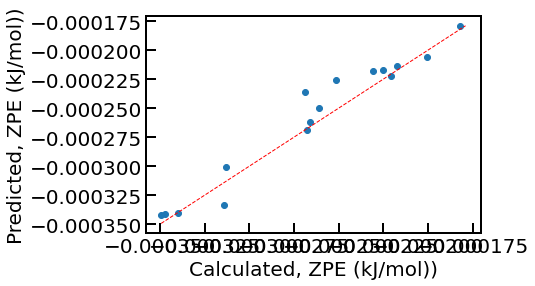

GB 0.9432487745224464
RMSE:  0.21630658826556148
RMSE unscaled:  1.2278408484213655e-05
----------------------------------------


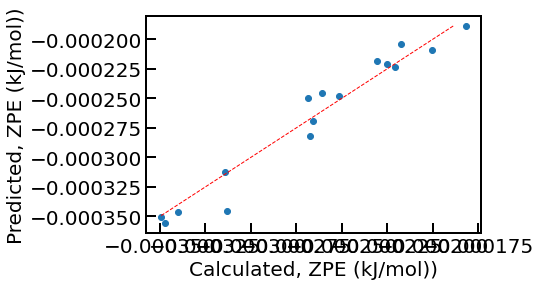

LR 0.35219570579828396
RMSE:  0.7308092516221115
RMSE unscaled:  4.1483593206335076e-05
----------------------------------------


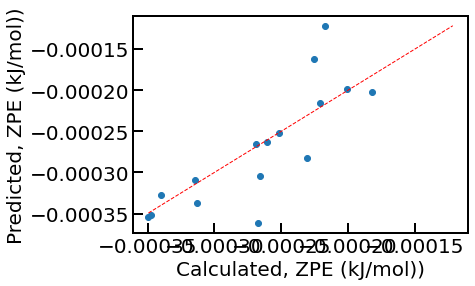

RR 0.6135924786366675
RMSE:  0.5644232706387247
RMSE unscaled:  3.2038873760006995e-05
----------------------------------------


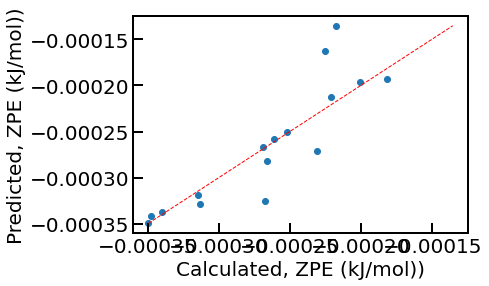

LASSO 0.9619449111994502
RMSE:  0.17712852053328995
RMSE unscaled:  1.0054508033024258e-05
----------------------------------------


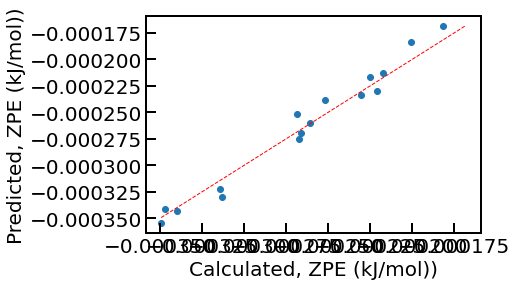

gpr1 0.8289385971173818
RMSE:  0.37554167590705817
RMSE unscaled:  2.1317215238825765e-05
----------------------------------------


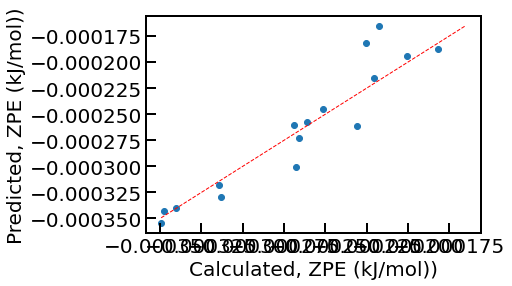

gpr2 0.982280006298278
RMSE:  0.12086871554523282
RMSE unscaled:  6.860981324362535e-06
----------------------------------------


gpr3 0.9833010239033504
RMSE:  0.11733485659387745
RMSE unscaled:  6.660385660225548e-06
----------------------------------------


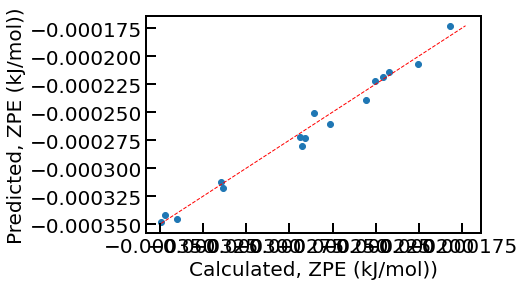

gpr4 0.9833010230716197
RMSE:  0.11733485951594302
RMSE unscaled:  6.660385826093422e-06
----------------------------------------


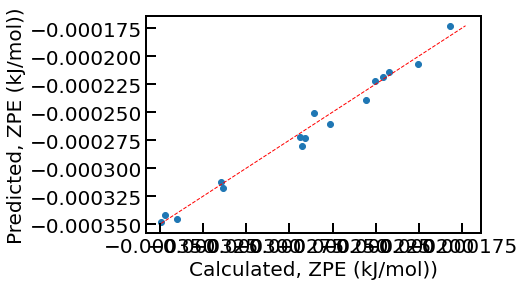

gpr5 -0.09596381715036428
RMSE:  0.9505615287839272
RMSE unscaled:  5.395759247729715e-05
----------------------------------------


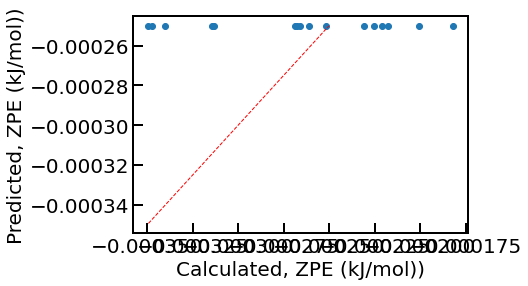

gpr6 0.9801295409279568
RMSE:  0.1279929579299709
RMSE unscaled:  7.26538120344975e-06
----------------------------------------


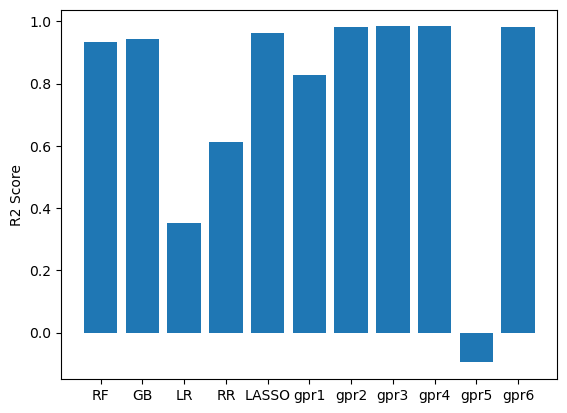

In [16]:
run_models()

In [17]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

     Feature      Score
1   mean_A2B  84.059383
25      X_EA  74.295393
14       X_Z  72.236289
32    X_Rvdw  60.135654
4   mean_X2X  52.111815
30    A_Rvdw  38.266002
2   mean_A2X  37.337976
18     A_IEI  25.262088
9      E_coh  19.078389
41      B_Hf  14.584107
29    A_ChiA  14.291225
26    A_ChiP  11.547615
17       X_G  11.273347
34      B_Ra  10.484972
44   X_Kappa   9.962184
6    std_A2X   9.665105
36      B_MP   9.662584
23      A_EA   9.476802
7    std_B2X   9.345726
35      A_MP   8.307610
12       A_Z   7.833143
11        OF   7.398681
45     A_CvM   5.949536
13       B_Z   5.849839
39      B_MV   5.720872
42   A_Kappa   5.090722
40      X_MV   4.778845
43   B_Kappa   3.792981
47       A_B   3.658663
15       A_G   3.167803


In [18]:
featureScores.nlargest(40,'Score')['Feature'].values

array(['mean_A2B', 'X_EA', 'X_Z', 'X_Rvdw', 'mean_X2X', 'A_Rvdw',
       'mean_A2X', 'A_IEI', 'E_coh', 'B_Hf', 'A_ChiA', 'A_ChiP', 'X_G',
       'B_Ra', 'X_Kappa', 'std_A2X', 'B_MP', 'A_EA', 'std_B2X', 'A_MP',
       'A_Z', 'OF', 'A_CvM', 'B_Z', 'B_MV', 'A_Kappa', 'X_MV', 'B_Kappa',
       'A_B', 'A_G', 'B_CvM', 'std_A2B', 'X_IEI', 'B_EA', 'B_Rvdw',
       'std_X2X', 'B_Rho', 'B_Rc', 'B_IEII', 'TF'], dtype=object)

In [19]:
X=X[featureScores.nlargest(40,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(40,'Score')['Feature'].values]

RF 0.9376217636844301
RMSE:  0.22677682519879408
RMSE unscaled:  1.2872740108708136e-05
----------------------------------------


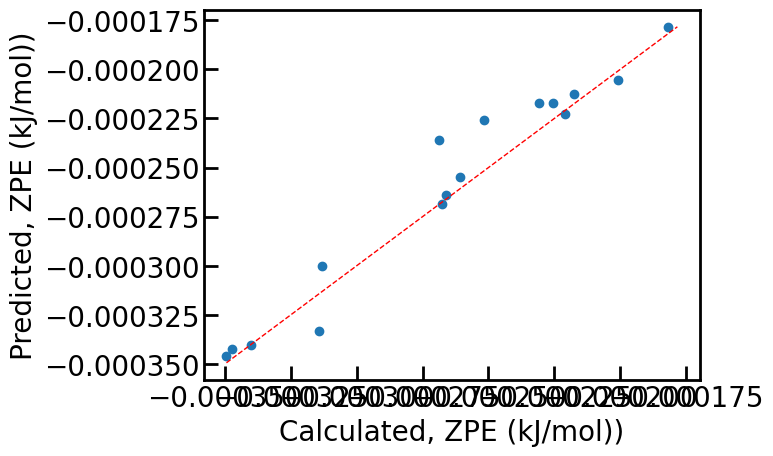

GB 0.9527300177363515
RMSE:  0.1974125893877708
RMSE unscaled:  1.1205911164636058e-05
----------------------------------------


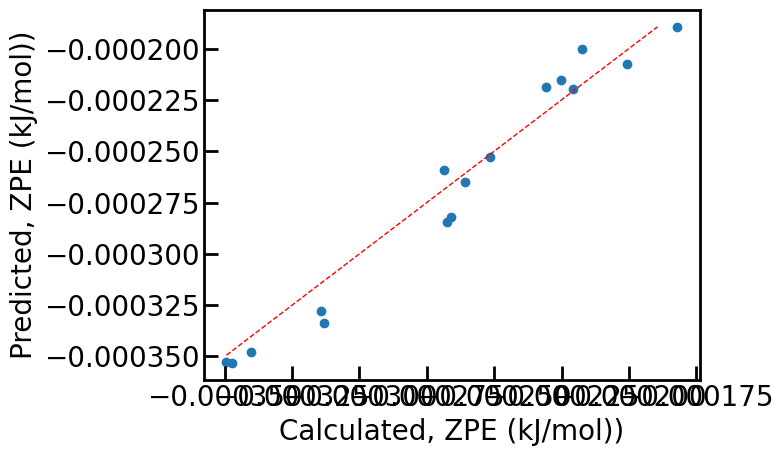

LR 0.947420367406237
RMSE:  0.2082048773236632
RMSE unscaled:  1.181852366441555e-05
----------------------------------------


RR 0.9452978484723048
RMSE:  0.212365678460033
RMSE unscaled:  1.2054707020565617e-05
----------------------------------------


LASSO 0.9628250147632704
RMSE:  0.17506830530627238
RMSE unscaled:  9.937562153910946e-06
----------------------------------------


gpr1 0.936887175545815
RMSE:  0.2281082189186206
RMSE unscaled:  1.2948315226768237e-05
----------------------------------------


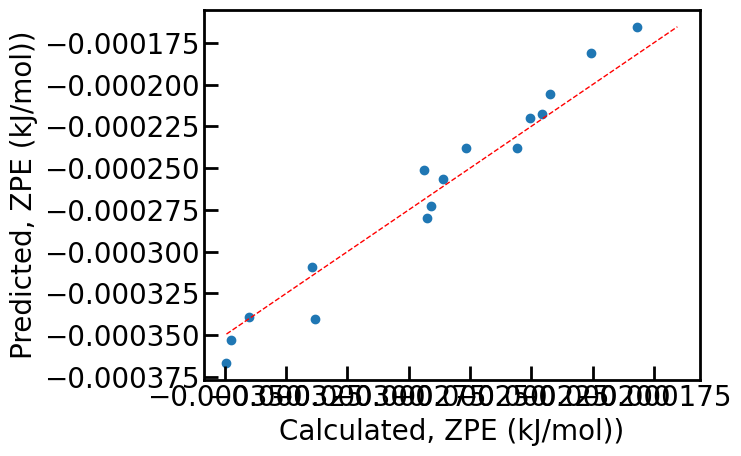

gpr2 0.9641521703200954
RMSE:  0.1719149158871109
RMSE unscaled:  9.758563429421212e-06
----------------------------------------


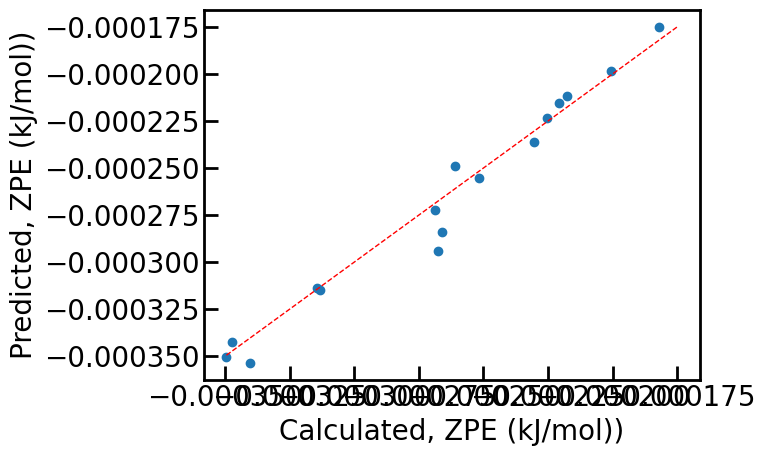

gpr3 0.9565884238224013
RMSE:  0.18918421730119214
RMSE unscaled:  1.0738836562566715e-05
----------------------------------------


gpr4 0.9565884246726839
RMSE:  0.18918421544846004
RMSE unscaled:  1.0738836457398391e-05
----------------------------------------


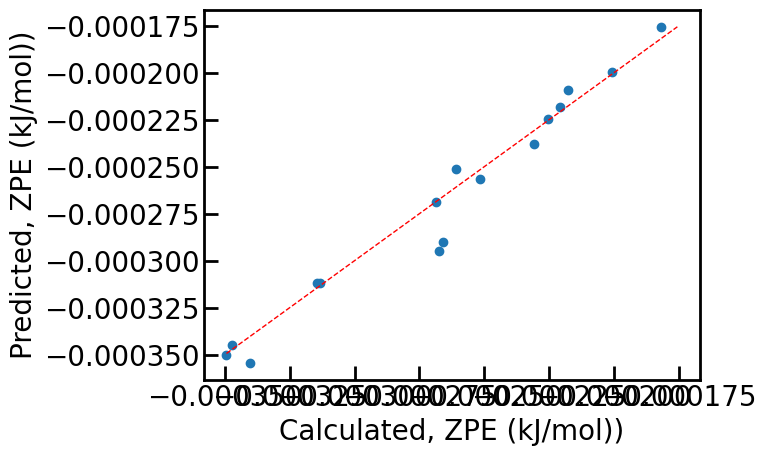

gpr5 0.9633951910808273
RMSE:  0.17372055069951162
RMSE unscaled:  9.861058327878734e-06
----------------------------------------


gpr6 0.9825847444769439
RMSE:  0.11982489327179172
RMSE unscaled:  6.801729887034622e-06
----------------------------------------


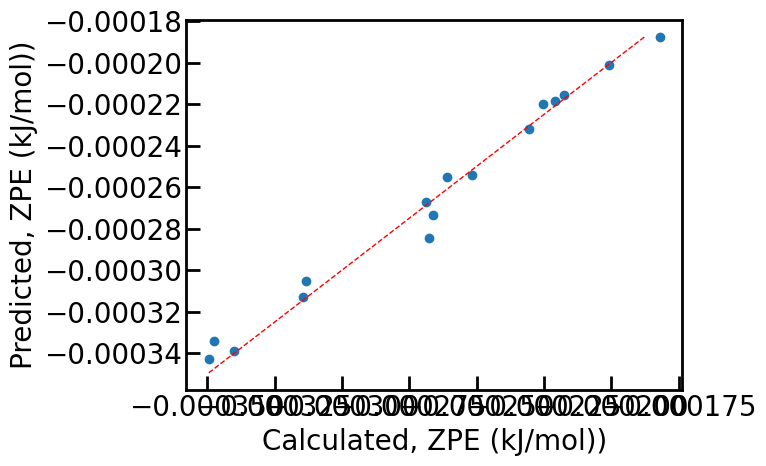

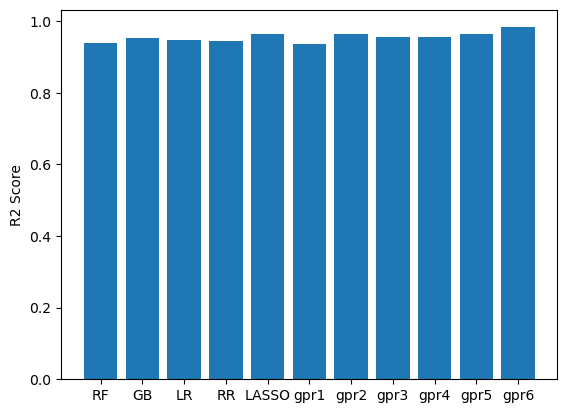

In [20]:
run_models()

In [21]:
featureScores.nlargest(30,'Score')['Feature'].values

array(['mean_A2B', 'X_EA', 'X_Z', 'X_Rvdw', 'mean_X2X', 'A_Rvdw',
       'mean_A2X', 'A_IEI', 'E_coh', 'B_Hf', 'A_ChiA', 'A_ChiP', 'X_G',
       'B_Ra', 'X_Kappa', 'std_A2X', 'B_MP', 'A_EA', 'std_B2X', 'A_MP',
       'A_Z', 'OF', 'A_CvM', 'B_Z', 'B_MV', 'A_Kappa', 'X_MV', 'B_Kappa',
       'A_B', 'A_G'], dtype=object)

In [22]:
X=X[featureScores.nlargest(30,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(30,'Score')['Feature'].values]

RF 0.9308773788056376
RMSE:  0.23872187927243368
RMSE unscaled:  1.3550788125914637e-05
----------------------------------------


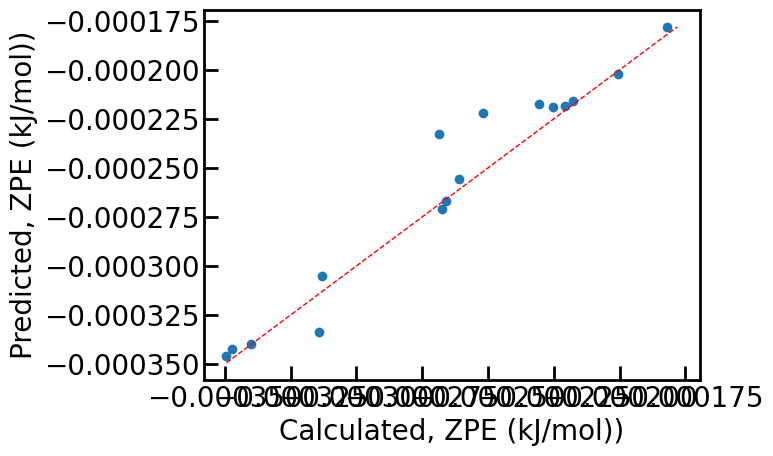

GB 0.9264538181609897
RMSE:  0.24624203462297065
RMSE unscaled:  1.3977661574379721e-05
----------------------------------------


LR 0.9391408978437896
RMSE:  0.22399838949455664
RMSE unscaled:  1.2715025224490791e-05
----------------------------------------


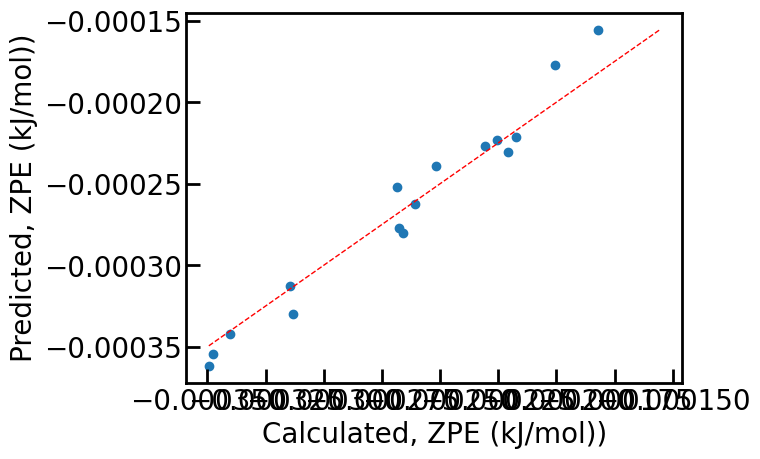

RR 0.9396168405676182
RMSE:  0.22312079146108382
RMSE unscaled:  1.2665209325556209e-05
----------------------------------------


LASSO 0.9686077703958786
RMSE:  0.1608767212120265
RMSE unscaled:  9.131992300748211e-06
----------------------------------------


gpr1 0.9423031738178717
RMSE:  0.21810121618041667
RMSE unscaled:  1.2380278588090061e-05
----------------------------------------


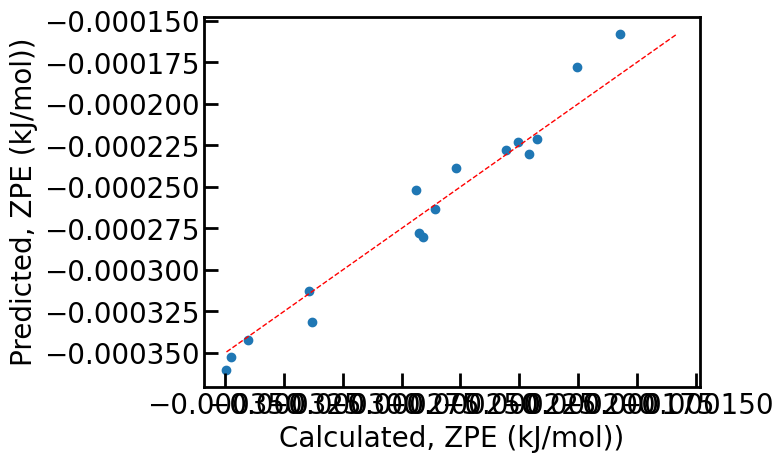

gpr2 0.9656220449694254
RMSE:  0.16835349818084508
RMSE unscaled:  9.556403422501974e-06
----------------------------------------


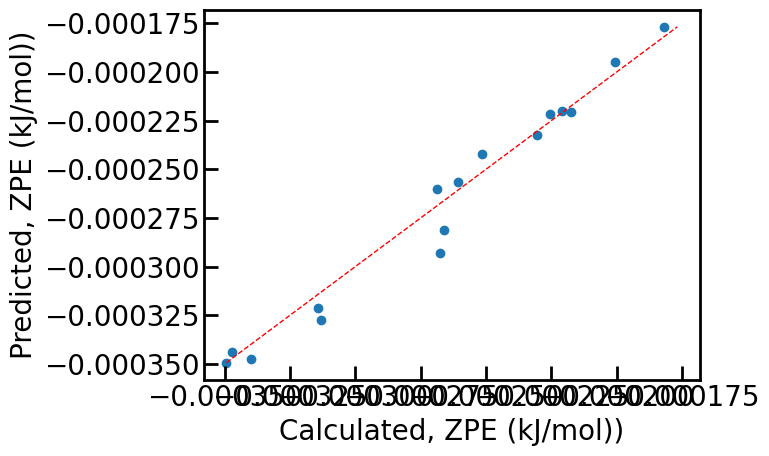

gpr3 0.9476926841091663
RMSE:  0.2076650174503767
RMSE unscaled:  1.1787879105220202e-05
----------------------------------------


gpr4 0.9476927128782817
RMSE:  0.20766496034230705
RMSE unscaled:  1.1787875863542678e-05
----------------------------------------


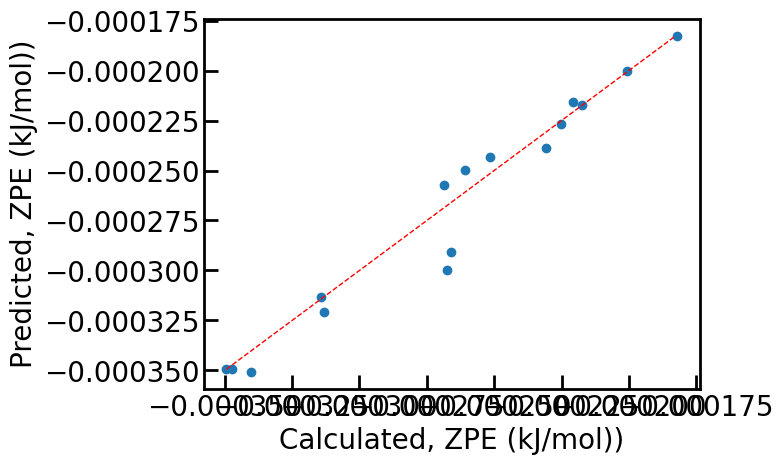

gpr5 0.9563275728719282
RMSE:  0.1897517499432031
RMSE unscaled:  1.0771051936414602e-05
----------------------------------------


gpr6 0.975328290377271
RMSE:  0.14262043206788488
RMSE unscaled:  8.095693881383916e-06
----------------------------------------


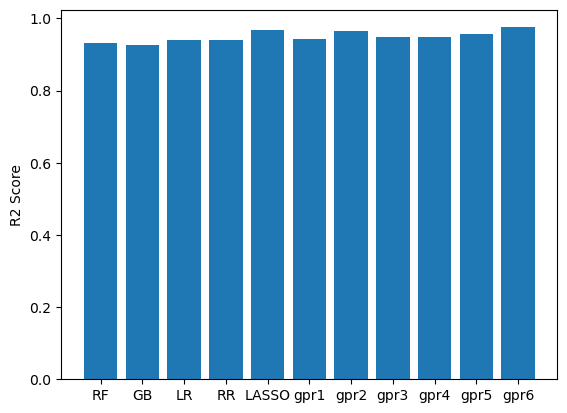

In [23]:
run_models()

In [24]:
featureScores.nlargest(20,'Score')['Feature'].values

array(['mean_A2B', 'X_EA', 'X_Z', 'X_Rvdw', 'mean_X2X', 'A_Rvdw',
       'mean_A2X', 'A_IEI', 'E_coh', 'B_Hf', 'A_ChiA', 'A_ChiP', 'X_G',
       'B_Ra', 'X_Kappa', 'std_A2X', 'B_MP', 'A_EA', 'std_B2X', 'A_MP'],
      dtype=object)

In [25]:
X=X[featureScores.nlargest(20,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(20,'Score')['Feature'].values]

RF 0.9296030351902942
RMSE:  0.24091236594190826
RMSE unscaled:  1.3675128721930205e-05
----------------------------------------


GB 0.9292719183299413
RMSE:  0.2414782750356968
RMSE unscaled:  1.3707251936827089e-05
----------------------------------------


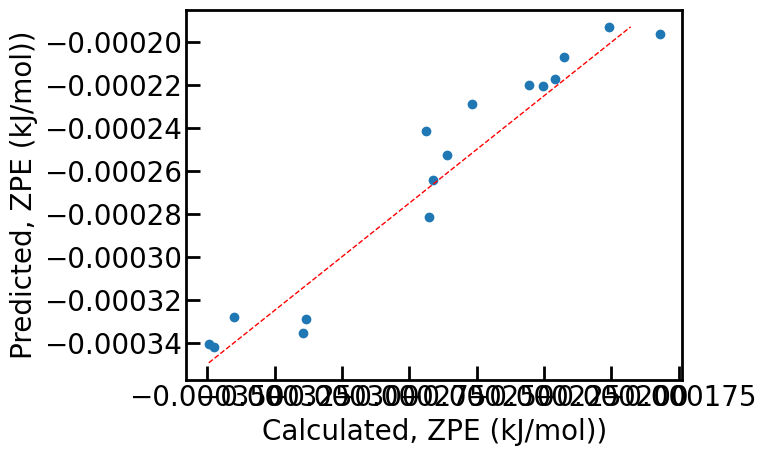

LR 0.939068894491258
RMSE:  0.22413085831798735
RMSE unscaled:  1.2722544673336743e-05
----------------------------------------


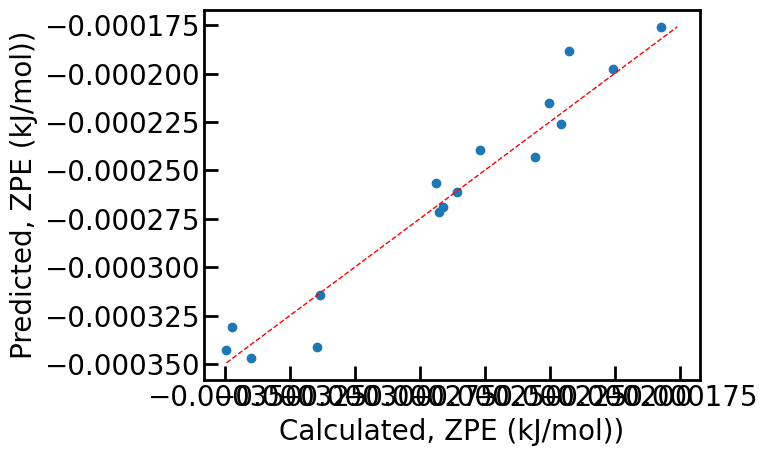

RR 0.939365709132939
RMSE:  0.22358428580602216
RMSE unscaled:  1.269151907849951e-05
----------------------------------------


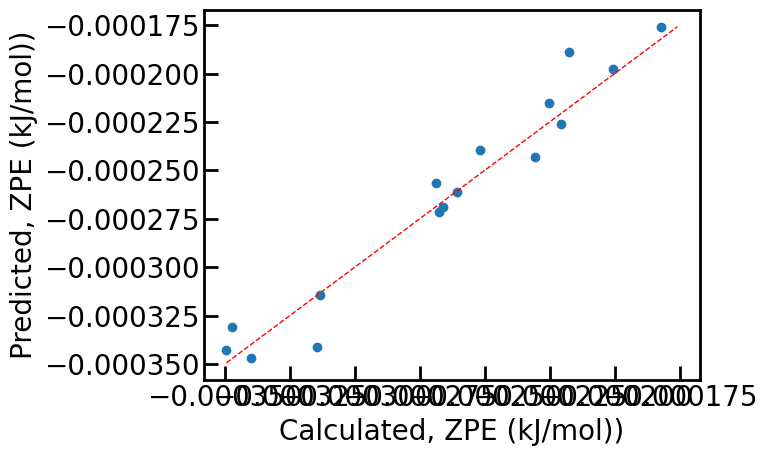

LASSO 0.9644131465759996
RMSE:  0.17128799276593654
RMSE unscaled:  9.722976819546309e-06
----------------------------------------


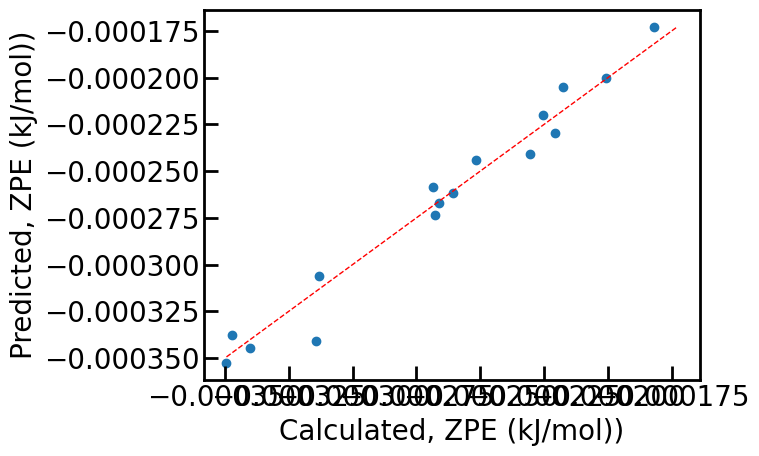

gpr1 0.9428555879318725
RMSE:  0.21705460777927377
RMSE unscaled:  1.2320868999250048e-05
----------------------------------------


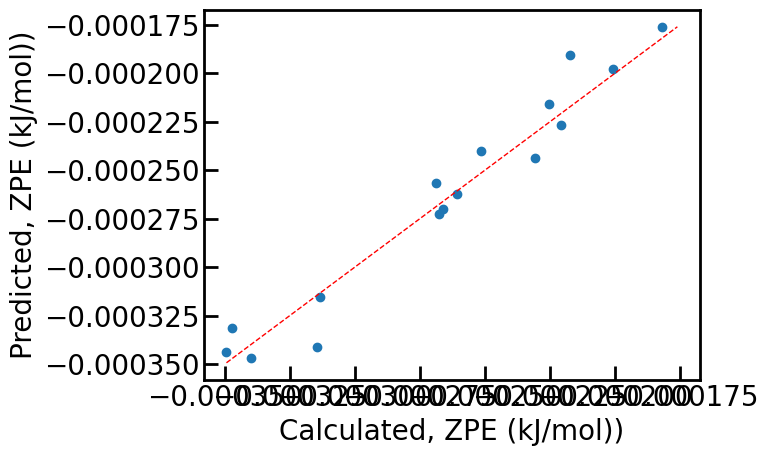

gpr2 0.968970746841795
RMSE:  0.1599439387612403
RMSE unscaled:  9.079043918318002e-06
----------------------------------------


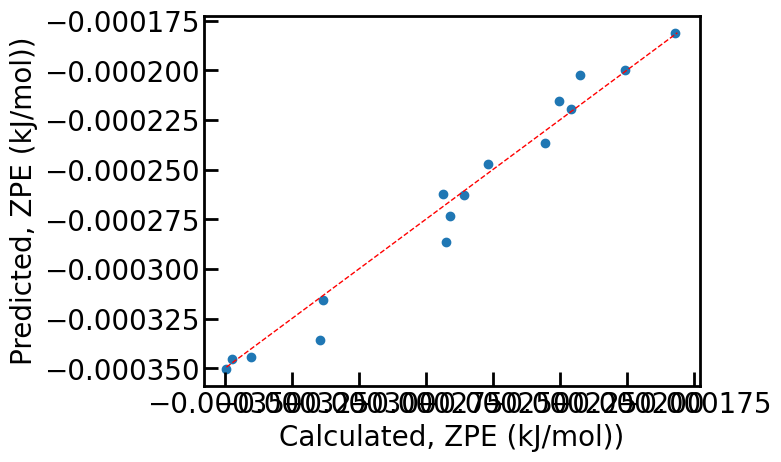

gpr3 0.9399809155004504
RMSE:  0.22244713091734689
RMSE unscaled:  1.2626969716665774e-05
----------------------------------------


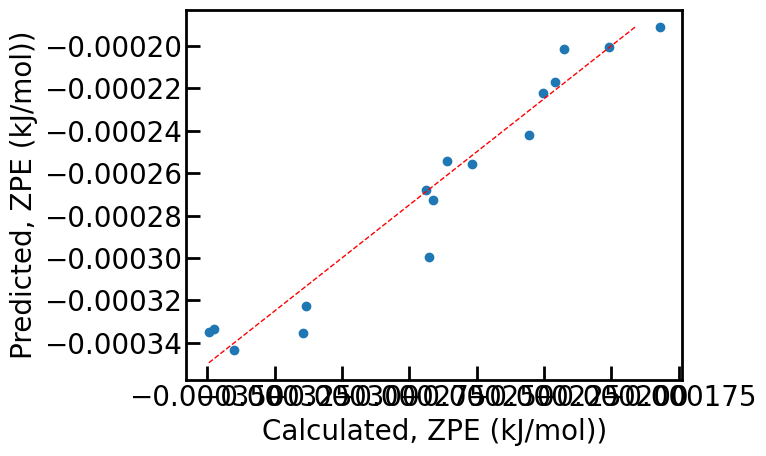

gpr4 0.9399809155366842
RMSE:  0.2224471308502008
RMSE unscaled:  1.26269697128543e-05
----------------------------------------


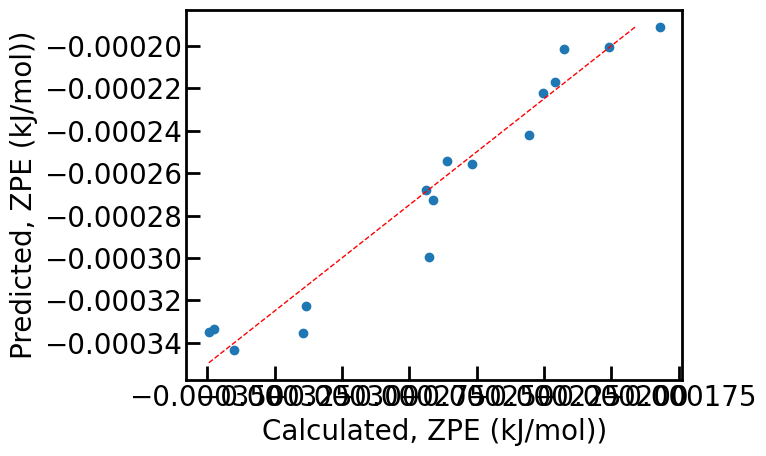

gpr5 0.9615925008507634
RMSE:  0.17794678263559835
RMSE unscaled:  1.0100955792289735e-05
----------------------------------------


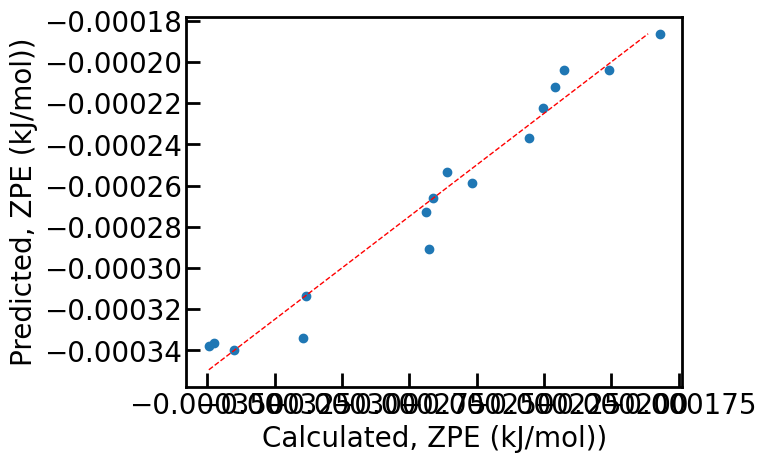

gpr6 0.9732735413483475
RMSE:  0.14844064537952725
RMSE unscaled:  8.426071966853347e-06
----------------------------------------


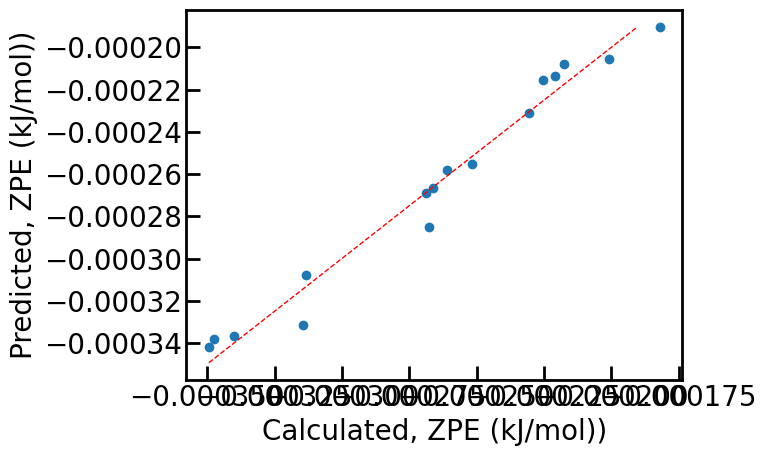

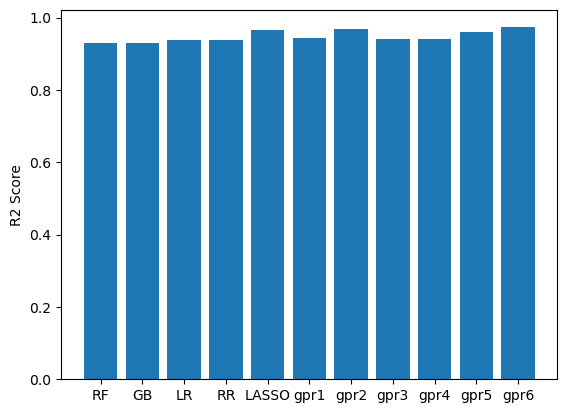

In [26]:
run_models()

In [27]:
featureScores.nlargest(10,'Score')['Feature'].values

array(['mean_A2B', 'X_EA', 'X_Z', 'X_Rvdw', 'mean_X2X', 'A_Rvdw',
       'mean_A2X', 'A_IEI', 'E_coh', 'B_Hf'], dtype=object)

In [28]:
X=X[featureScores.nlargest(10,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(10,'Score')['Feature'].values]

RF 0.9322366799095145
RMSE:  0.23636298363561314
RMSE unscaled:  1.3416887977829679e-05
----------------------------------------


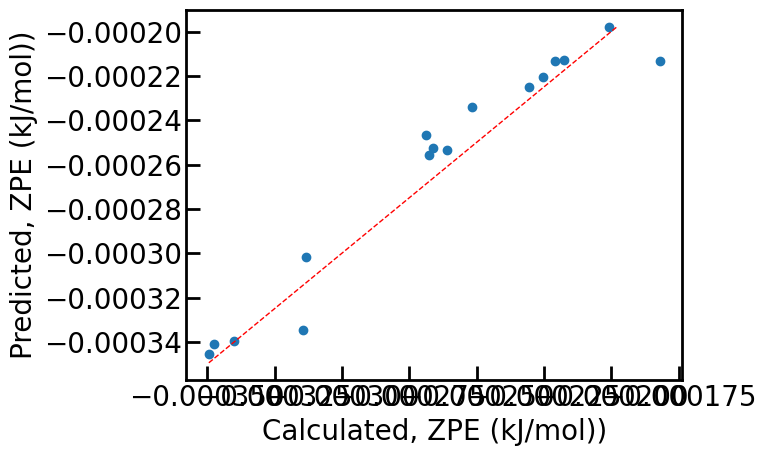

GB 0.9650610183040893
RMSE:  0.16972165067447156
RMSE unscaled:  9.634065112421546e-06
----------------------------------------


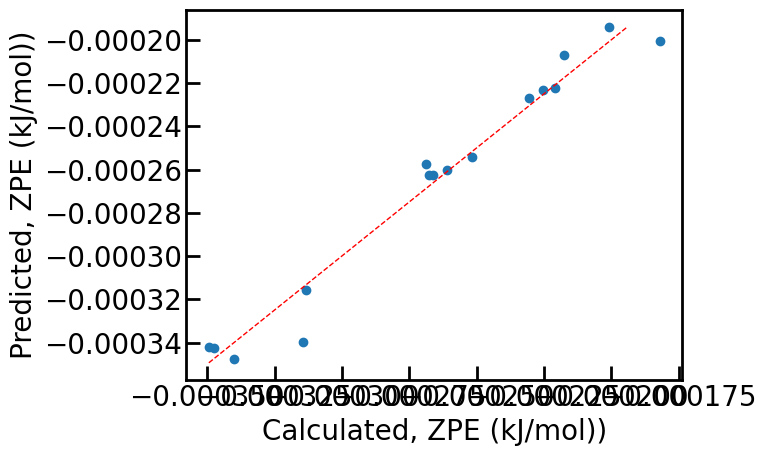

LR 0.9441959188733879
RMSE:  0.21449397915969626
RMSE unscaled:  1.2175517697564585e-05
----------------------------------------


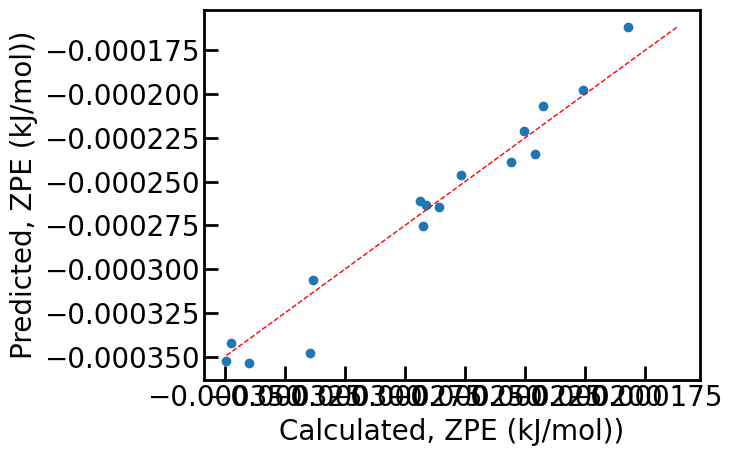

RR 0.9442694607531021
RMSE:  0.2143525962124817
RMSE unscaled:  1.2167492248166488e-05
----------------------------------------


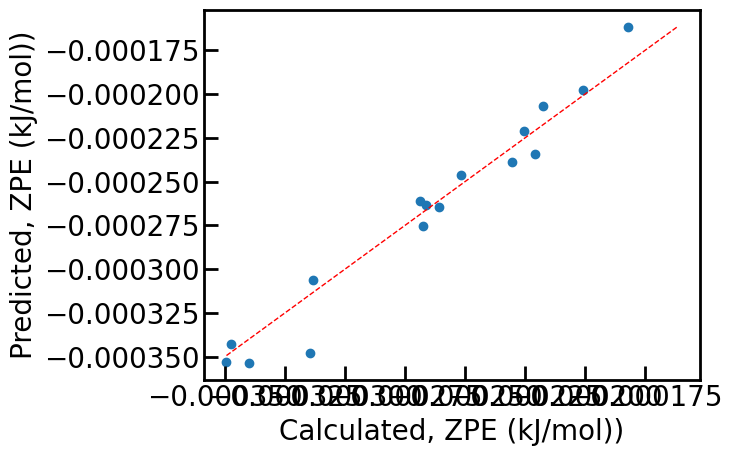

LASSO 0.9538230631290636
RMSE:  0.19511680943325135
RMSE unscaled:  1.1075593709687116e-05
----------------------------------------


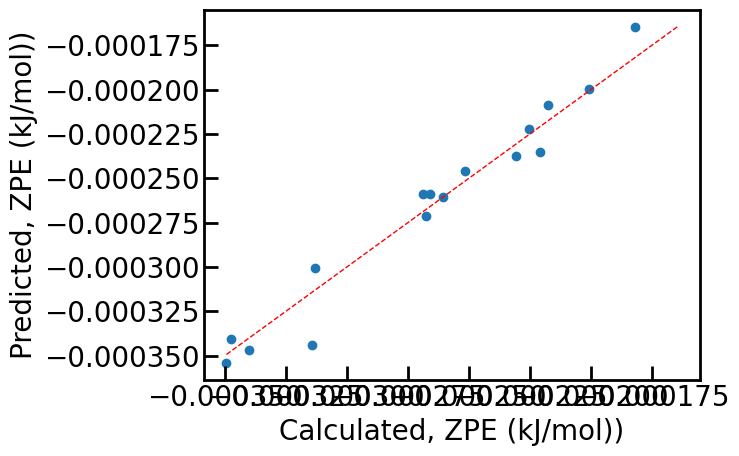

gpr1 0.9452657093621117
RMSE:  0.21242805481578478
RMSE unscaled:  1.2058247746633259e-05
----------------------------------------


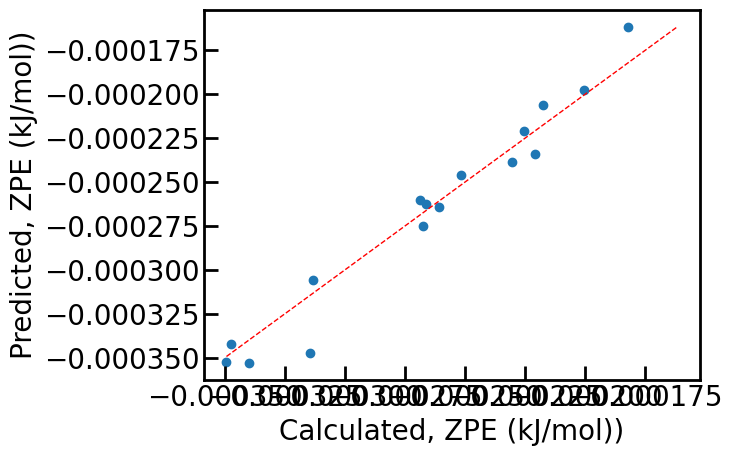

gpr2 0.9606090763637631
RMSE:  0.18021054806788492
RMSE unscaled:  1.0229455977665187e-05
----------------------------------------


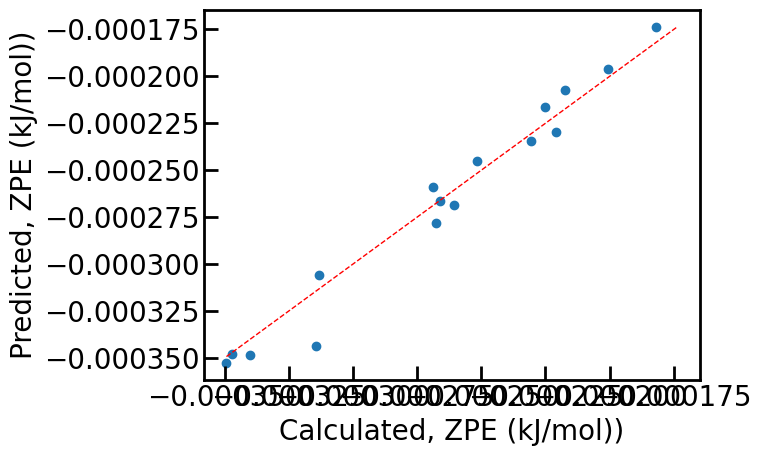

gpr3 0.9269130636314252
RMSE:  0.24547202437266616
RMSE unscaled:  1.3933952779071734e-05
----------------------------------------


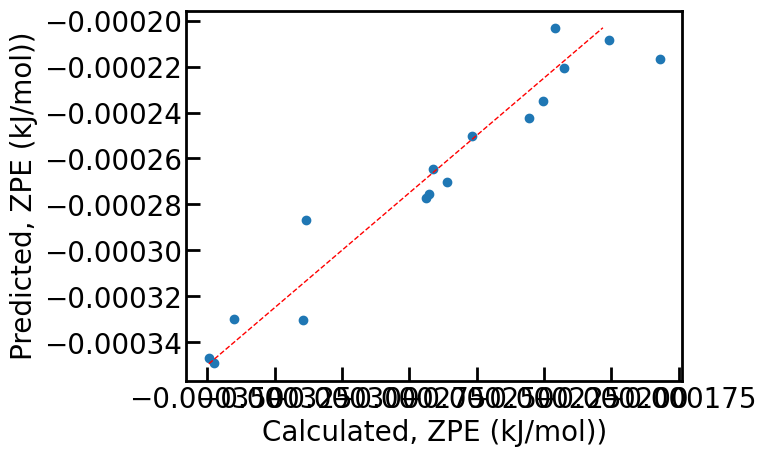

gpr4 0.9269130671900699
RMSE:  0.24547201839657948
RMSE unscaled:  1.3933952439845666e-05
----------------------------------------


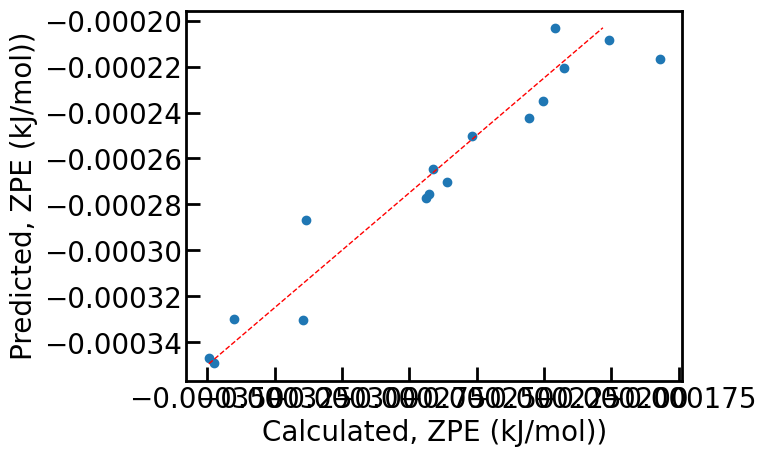

gpr5 0.9612935703149006
RMSE:  0.17863793183419893
RMSE unscaled:  1.0140188125673564e-05
----------------------------------------


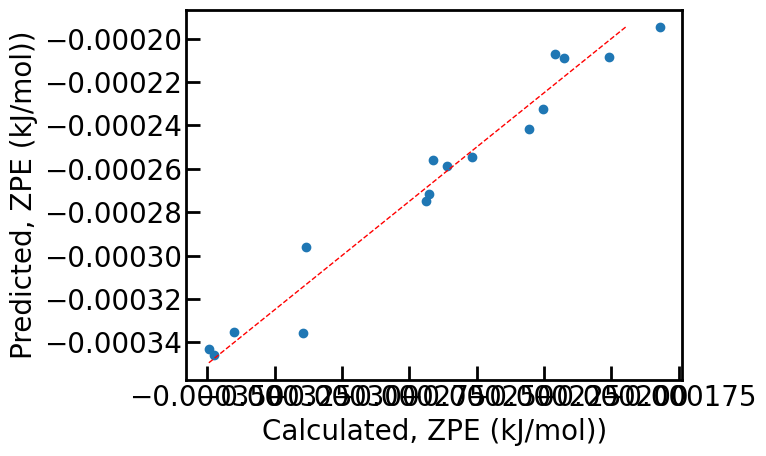

gpr6 0.9771410432896019
RMSE:  0.13728096645633078
RMSE unscaled:  7.792604916818552e-06
----------------------------------------


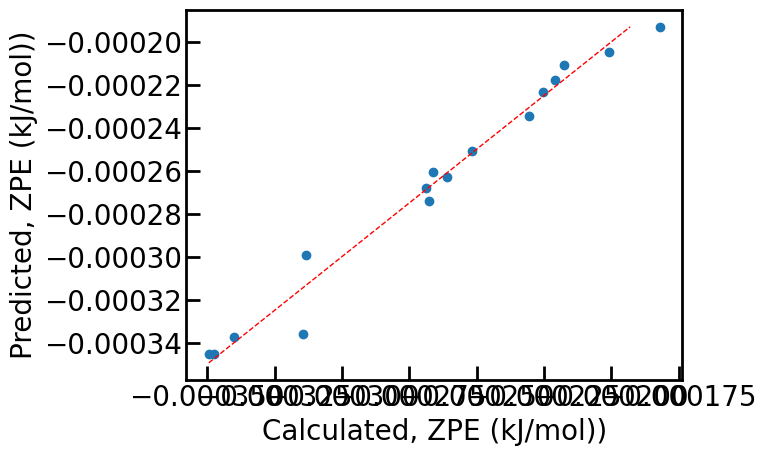

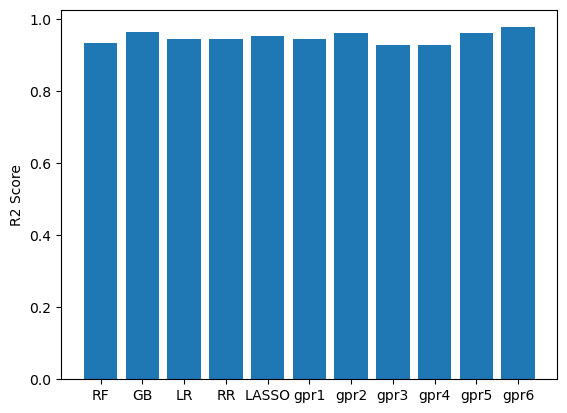

In [29]:
run_models()

# Min-Max scaling

In [30]:
data_std=d.copy()
scaler=MinMaxScaler()
scaler.fit(np.array(data['Coef_b']).reshape(-1, 1))
data_zpe_mm= scaler.transform(np.array(data['Coef_b']).reshape(-1, 1))
data_std[columns]= MinMaxScaler().fit_transform(d[columns])
Y = data_std['Coef_b'] 
X = data_std.drop(['Coef_b'], axis=1)

In [31]:
corrmat = X.corr()
top_corr_features = corrmat.index
correlated_features = set()
#plt.figure(figsize=(20,20))
#plot heat map
#g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn" )

In [32]:
for i in range(len(X.columns)):
    for j in range(i):
        if abs(corrmat.iloc[i, j]) > 0.9:
            colname = corrmat.columns[i]
            correlated_features.add(colname)
len(correlated_features)
print(correlated_features)

{'A_Rc', 'A_MV', 'A_BP', 'X_Hf', 'A_Hv', 'B_Hv', 'A_Hf', 'X_MP', 'X_Hv', 'X_M', 'A_Ra', 'A_M', 'A_MendeleevNo', 'X_Rc', 'X_BP', 'X_MendeleevNo', 'X_ChiA', 'X_IEII', 'B_M', 'X_CvM', 'B_BP', 'X_Ra', 'X_B'}


In [33]:
data_std.drop(labels=correlated_features, axis=1, inplace=True)
data_std.shape
#data_std.to_csv('scaled_non_corr_all.csv',index=False)

(80, 51)

In [34]:
print(correlated_features)

{'A_Rc', 'A_MV', 'A_BP', 'X_Hf', 'A_Hv', 'B_Hv', 'A_Hf', 'X_MP', 'X_Hv', 'X_M', 'A_Ra', 'A_M', 'A_MendeleevNo', 'X_Rc', 'X_BP', 'X_MendeleevNo', 'X_ChiA', 'X_IEII', 'B_M', 'X_CvM', 'B_BP', 'X_Ra', 'X_B'}


### Test-train splitting 

In [35]:
# split into train and test
df_train, df_test = train_test_split(data_std, 
                                     train_size = 0.8, 
                                     test_size = 0.2, 
                                     random_state = 100)
df_train.reset_index(inplace = True)
df_test.reset_index(inplace = True)
df_train=df_train.drop('index',axis=1)
df_test=df_test.drop('index',axis=1)
# divide into X_train, y_train, X_test, y_test
Y = df_train.pop('Coef_b')
X = df_train

Y_test = df_test.pop('Coef_b')
X_test = df_test

RF 0.9306476509339212
RMSE:  0.06385997854838792
RMSE unscaled:  1.357328735595023e-05
----------------------------------------


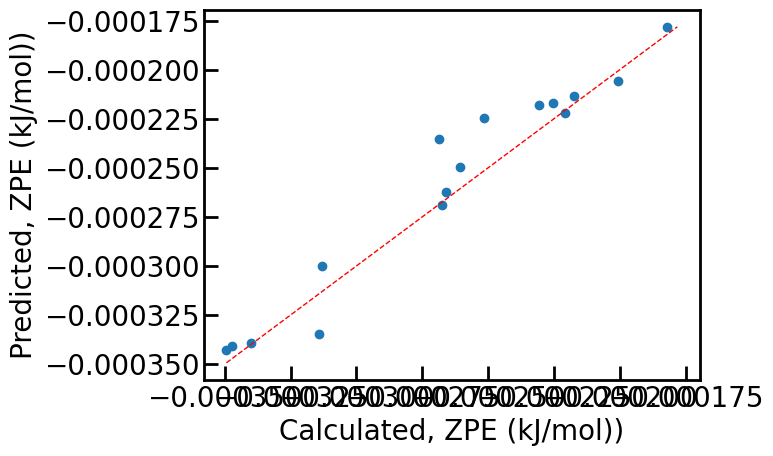

GB 0.9146099708739007
RMSE:  0.07086010005704606
RMSE unscaled:  1.5061146621226843e-05
----------------------------------------


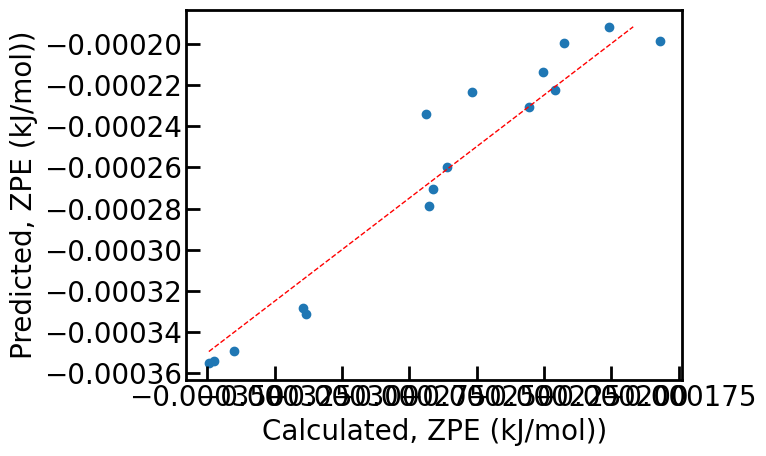

LR 0.35219570579828086
RMSE:  0.19517315907301486
RMSE unscaled:  4.148359320633518e-05
----------------------------------------


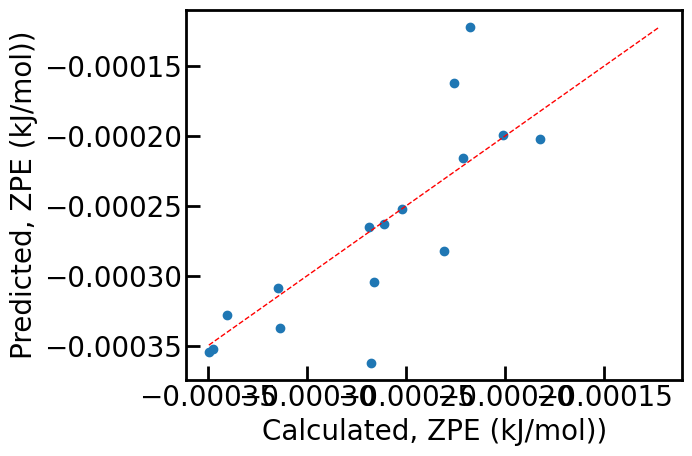

RR 0.8983097551810618
RMSE:  0.07732818678726448
RMSE unscaled:  1.6435923153072063e-05
----------------------------------------


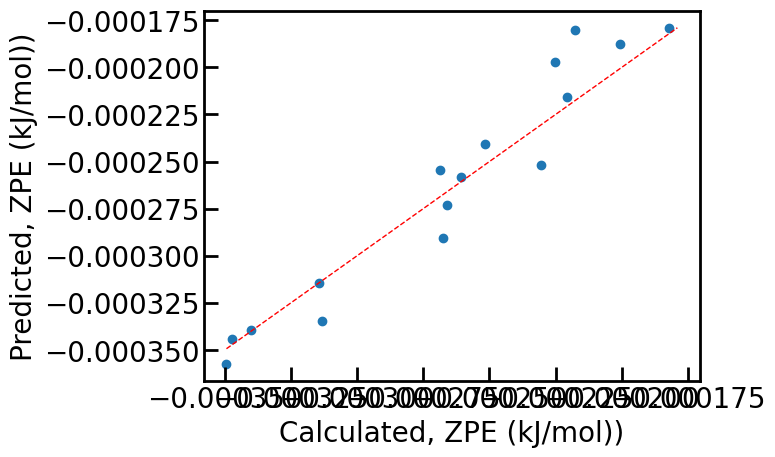

LASSO 0.9216815523469979
RMSE:  0.06786255642526379
RMSE unscaled:  1.4424025814094866e-05
----------------------------------------


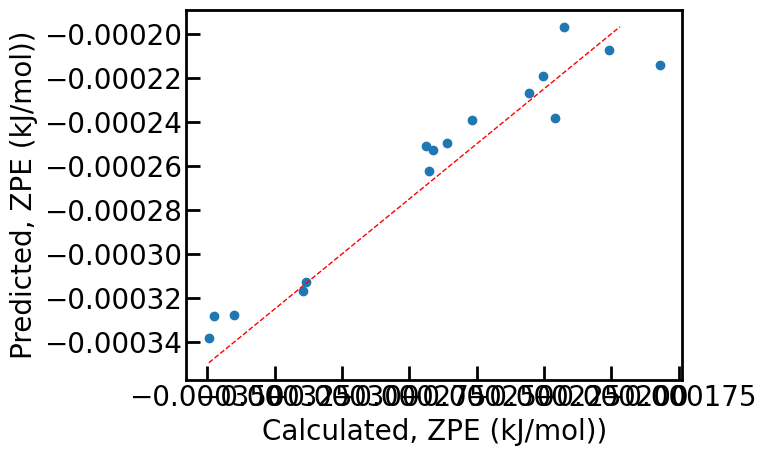

gpr1 0.8447100711274684
RMSE:  0.09555861045164614
RMSE unscaled:  2.031075657209479e-05
----------------------------------------


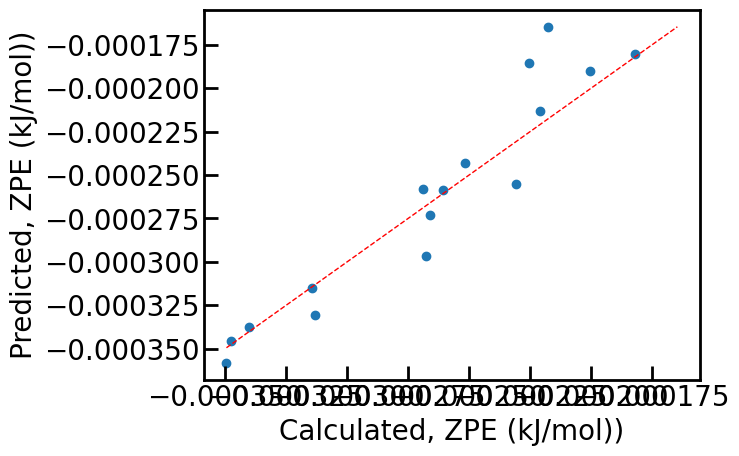

gpr2 0.9779595395606786
RMSE:  0.03600049828243172
RMSE unscaled:  7.651820737374395e-06
----------------------------------------


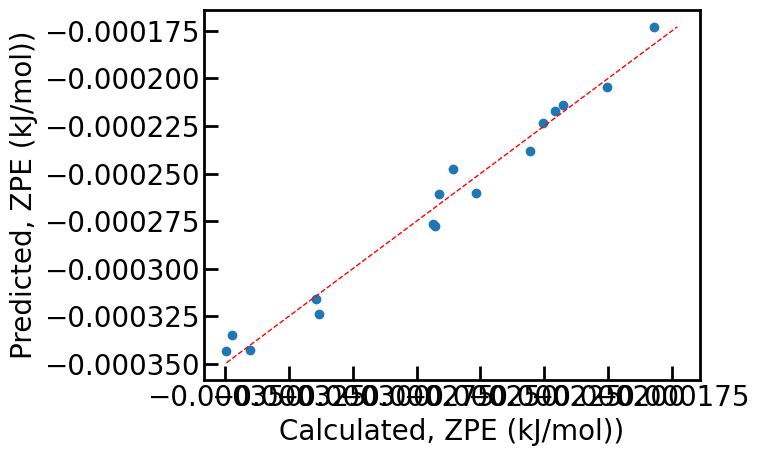

gpr3 0.9826946527077656
RMSE:  0.03189982790211561
RMSE unscaled:  6.7802329496978e-06
----------------------------------------


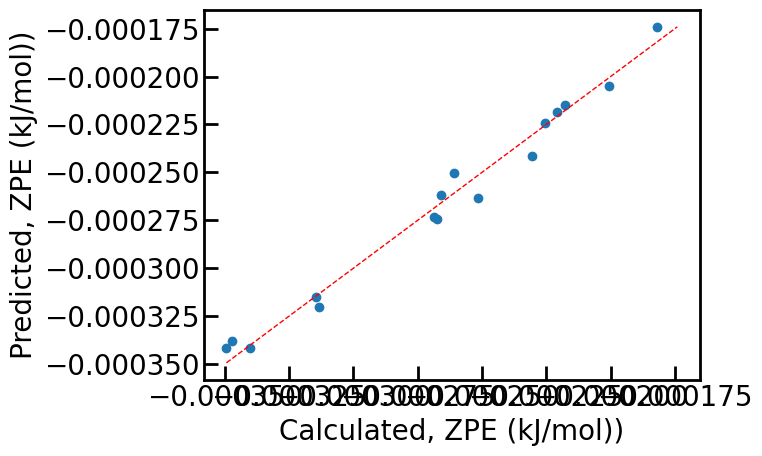

gpr4 0.9826946530850296
RMSE:  0.03189982755440061
RMSE unscaled:  6.780232875791794e-06
----------------------------------------


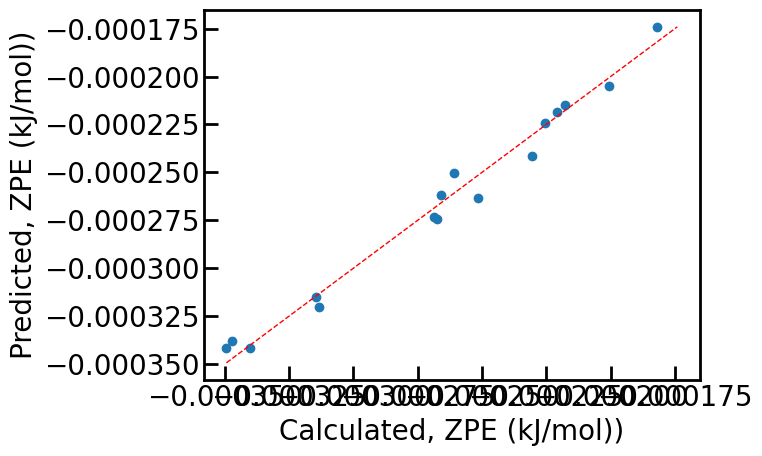

gpr5 0.9829864717661168
RMSE:  0.03162972190008079
RMSE unscaled:  6.722822558001418e-06
----------------------------------------


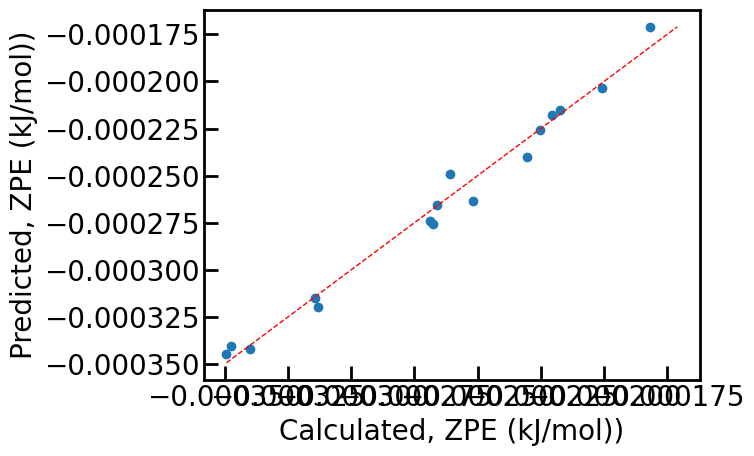

gpr6 0.9844831524804823
RMSE:  0.030206466596095174
RMSE unscaled:  6.4203130103785735e-06
----------------------------------------


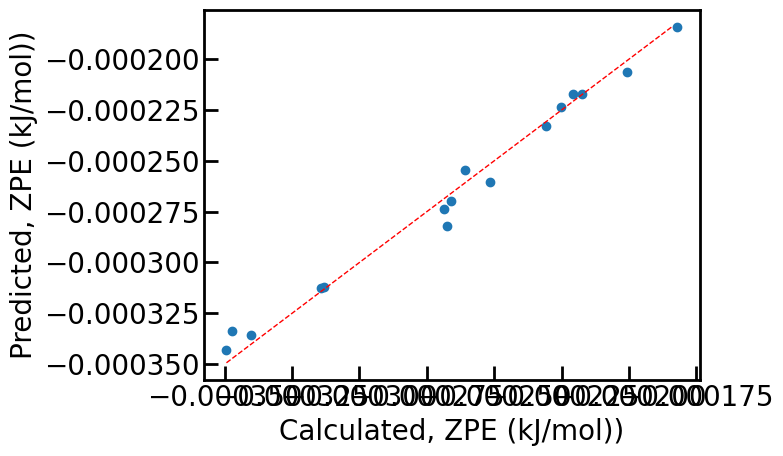

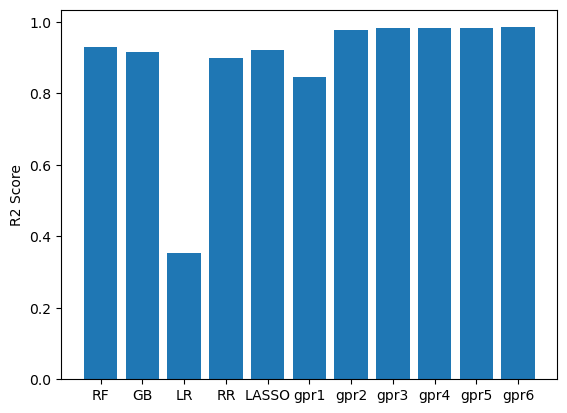

In [36]:
run_models()

## Feature selection


In [37]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

     Feature      Score
1   mean_A2B  84.059383
25      X_EA  74.295393
14       X_Z  72.236289
32    X_Rvdw  60.135654
4   mean_X2X  52.111815
30    A_Rvdw  38.266002
2   mean_A2X  37.337976
18     A_IEI  25.262088
9      E_coh  19.078389
41      B_Hf  14.584107
29    A_ChiA  14.291225
26    A_ChiP  11.547615
17       X_G  11.273347
34      B_Ra  10.484972
44   X_Kappa   9.962184
6    std_A2X   9.665105
36      B_MP   9.662584
23      A_EA   9.476802
7    std_B2X   9.345726
35      A_MP   8.307610
12       A_Z   7.833143
11        OF   7.398681
45     A_CvM   5.949536
13       B_Z   5.849839
39      B_MV   5.720872
42   A_Kappa   5.090722
40      X_MV   4.778845
43   B_Kappa   3.792981
47       A_B   3.658663
15       A_G   3.167803


In [38]:
featureScores.nlargest(40,'Score')['Feature'].values

array(['mean_A2B', 'X_EA', 'X_Z', 'X_Rvdw', 'mean_X2X', 'A_Rvdw',
       'mean_A2X', 'A_IEI', 'E_coh', 'B_Hf', 'A_ChiA', 'A_ChiP', 'X_G',
       'B_Ra', 'X_Kappa', 'std_A2X', 'B_MP', 'A_EA', 'std_B2X', 'A_MP',
       'A_Z', 'OF', 'A_CvM', 'B_Z', 'B_MV', 'A_Kappa', 'X_MV', 'B_Kappa',
       'A_B', 'A_G', 'B_CvM', 'std_A2B', 'X_IEI', 'B_EA', 'B_Rvdw',
       'std_X2X', 'B_Rho', 'B_Rc', 'B_IEII', 'TF'], dtype=object)

In [39]:
X=X[featureScores.nlargest(40,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(40,'Score')['Feature'].values]

RF 0.9356570482620788
RMSE:  0.06151041689883665
RMSE unscaled:  1.3073893586099294e-05
----------------------------------------


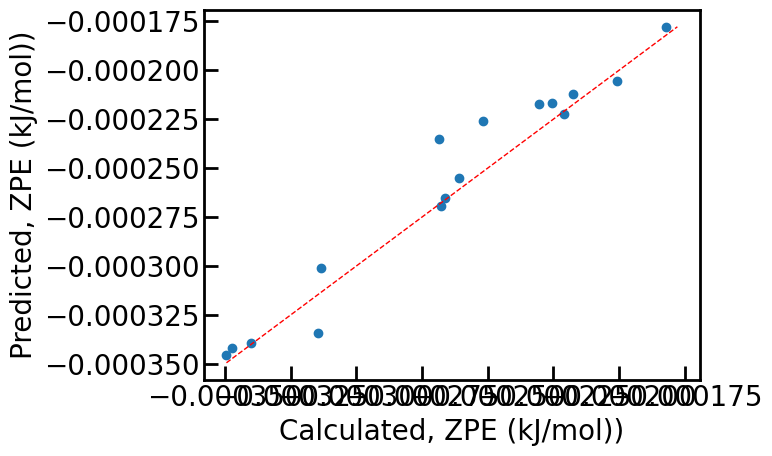

GB 0.9408712602428897
RMSE:  0.058965432962980624
RMSE unscaled:  1.2532963271638308e-05
----------------------------------------


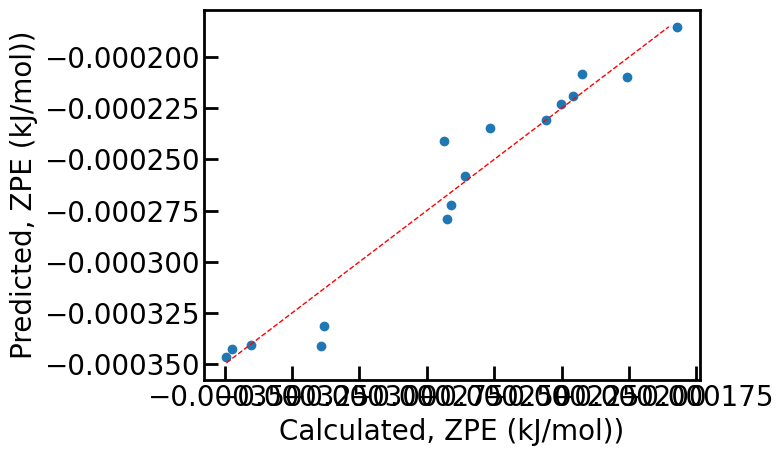

LR 0.9474203674062378
RMSE:  0.05560411769756935
RMSE unscaled:  1.181852366441546e-05
----------------------------------------


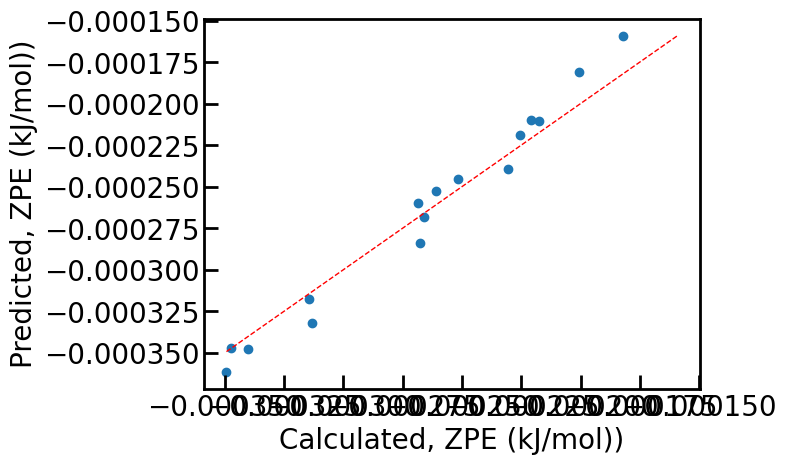

RR 0.9293520953617898
RMSE:  0.06445369552440124
RMSE unscaled:  1.3699480494543734e-05
----------------------------------------


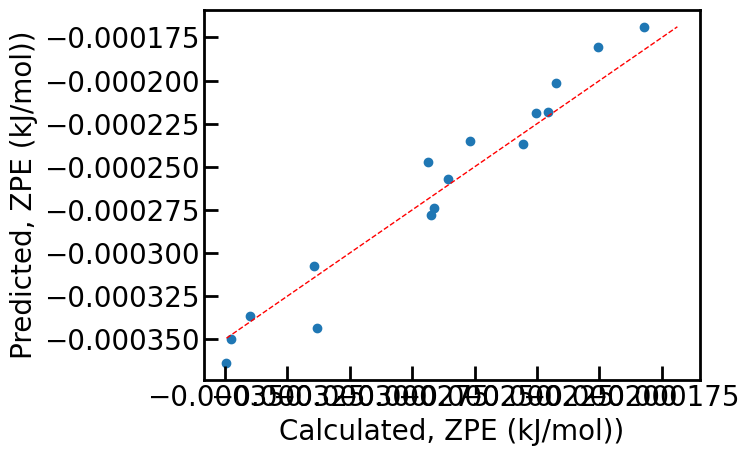

LASSO 0.9216457352080134
RMSE:  0.06787807234042857
RMSE unscaled:  1.4427323685154478e-05
----------------------------------------


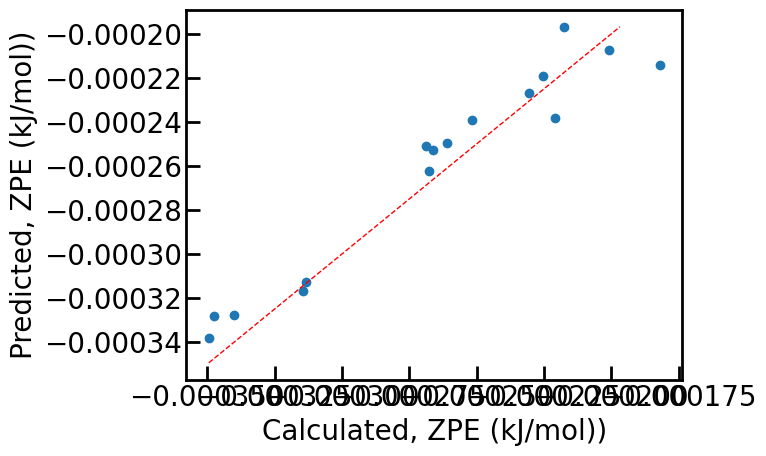

gpr1 0.9220536185470961
RMSE:  0.06770116773820102
RMSE unscaled:  1.4389723030484592e-05
----------------------------------------


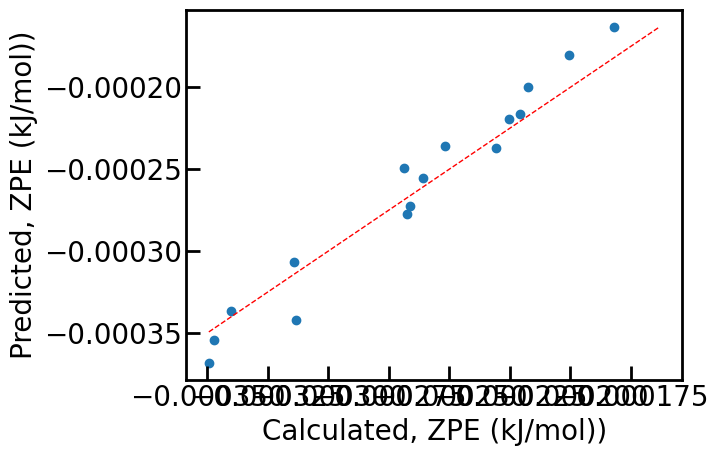

gpr2 0.9753959433464758
RMSE:  0.03803658687221514
RMSE unscaled:  8.08458655000869e-06
----------------------------------------


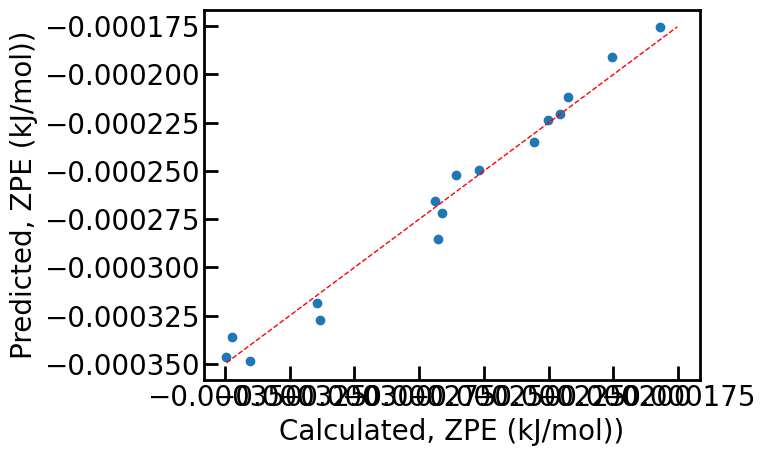

gpr3 0.9749300728934619
RMSE:  0.038395003895920356
RMSE unscaled:  8.160767240428572e-06
----------------------------------------


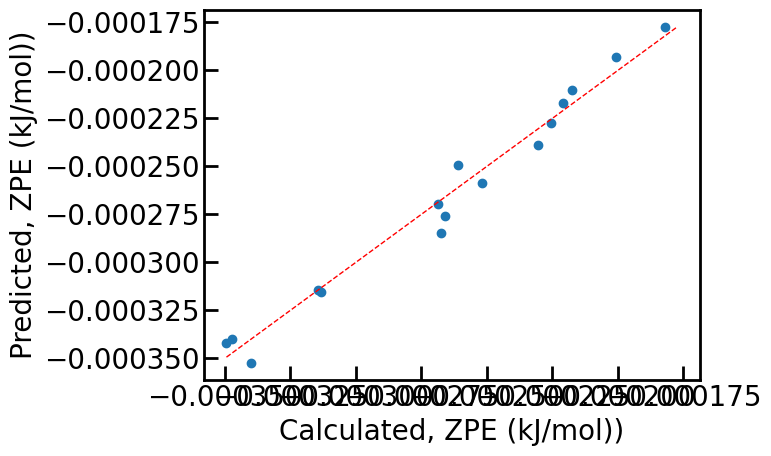

gpr4 0.9749300706711229
RMSE:  0.03839500559769461
RMSE unscaled:  8.16076760213667e-06
----------------------------------------


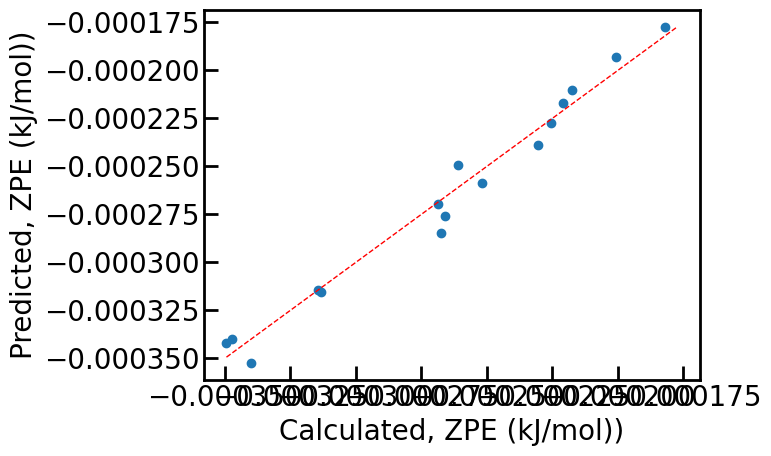

gpr5 0.9757524143371747
RMSE:  0.037760038770321684
RMSE unscaled:  8.025806905228536e-06
----------------------------------------


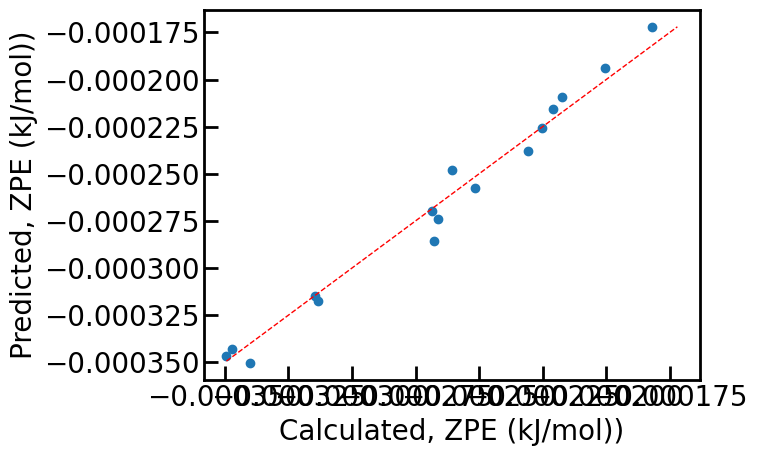

gpr6 0.9856593279911011
RMSE:  0.029039085263709873
RMSE unscaled:  6.172188870054417e-06
----------------------------------------


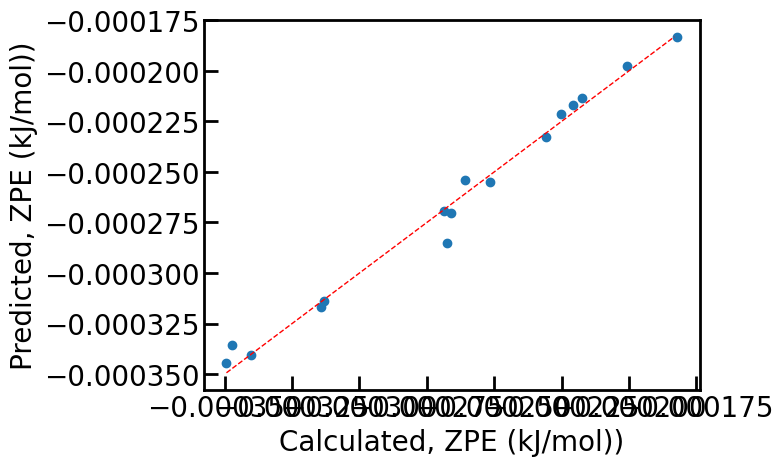

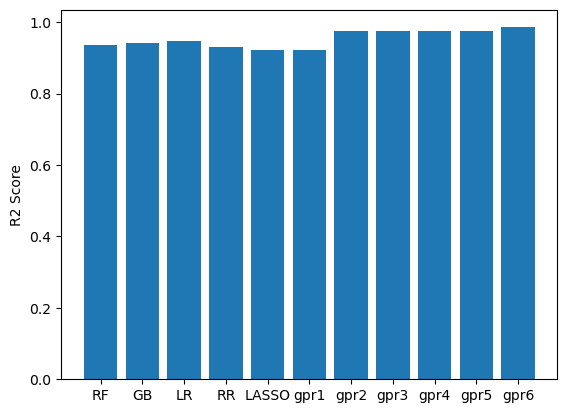

In [40]:
run_models()

In [41]:
featureScores.nlargest(30,'Score')['Feature'].values

array(['mean_A2B', 'X_EA', 'X_Z', 'X_Rvdw', 'mean_X2X', 'A_Rvdw',
       'mean_A2X', 'A_IEI', 'E_coh', 'B_Hf', 'A_ChiA', 'A_ChiP', 'X_G',
       'B_Ra', 'X_Kappa', 'std_A2X', 'B_MP', 'A_EA', 'std_B2X', 'A_MP',
       'A_Z', 'OF', 'A_CvM', 'B_Z', 'B_MV', 'A_Kappa', 'X_MV', 'B_Kappa',
       'A_B', 'A_G'], dtype=object)

In [42]:
X=X[featureScores.nlargest(30,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(30,'Score')['Feature'].values]

RF 0.9299365029477201
RMSE:  0.0641865577404043
RMSE unscaled:  1.3642700990568876e-05
----------------------------------------


GB 0.9499044578812523
RMSE:  0.05427473613927277
RMSE unscaled:  1.1535966759345594e-05
----------------------------------------


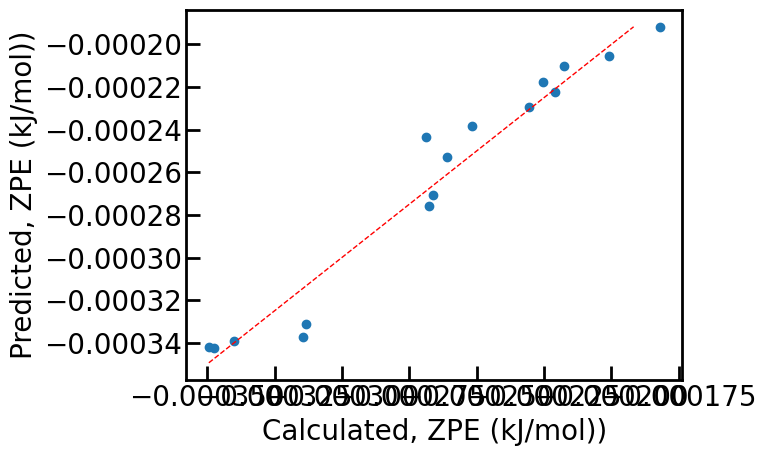

LR 0.9391408978437897
RMSE:  0.05982200308477504
RMSE unscaled:  1.2715025224490778e-05
----------------------------------------


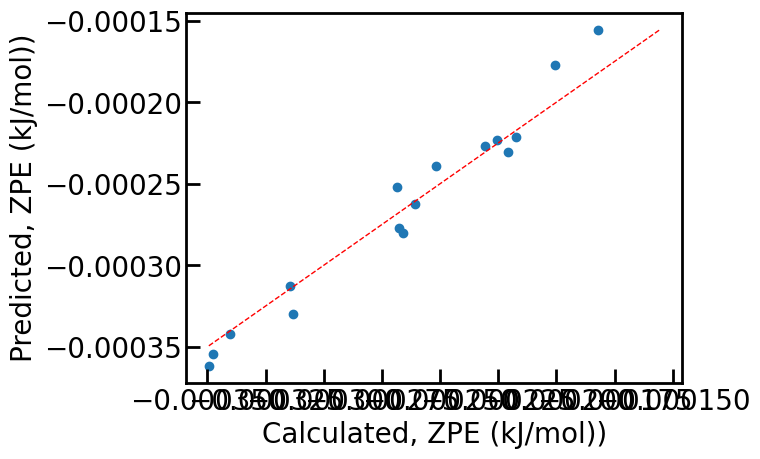

RR 0.9454385592042741
RMSE:  0.0566423281188512
RMSE unscaled:  1.2039192833186367e-05
----------------------------------------


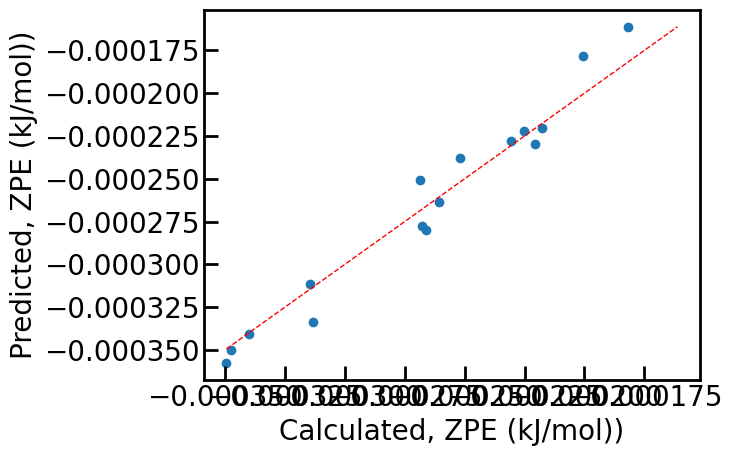

LASSO 0.9216457352080134
RMSE:  0.06787807234042857
RMSE unscaled:  1.4427323685154478e-05
----------------------------------------


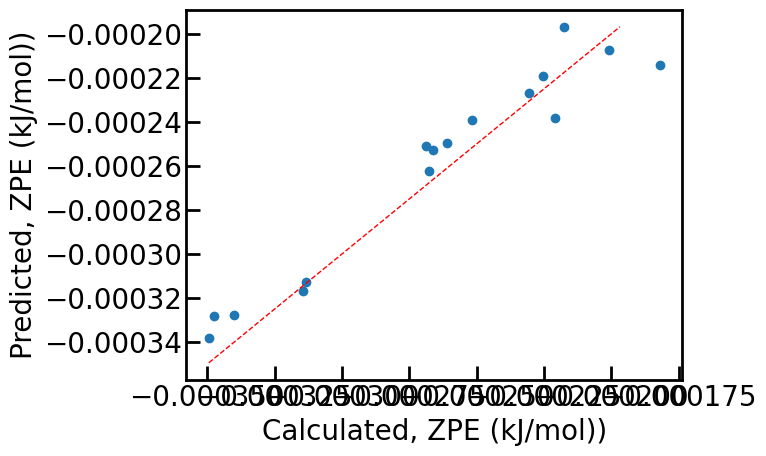

gpr1 0.9391415767454524
RMSE:  0.05982166941758981
RMSE unscaled:  1.2714954304319973e-05
----------------------------------------


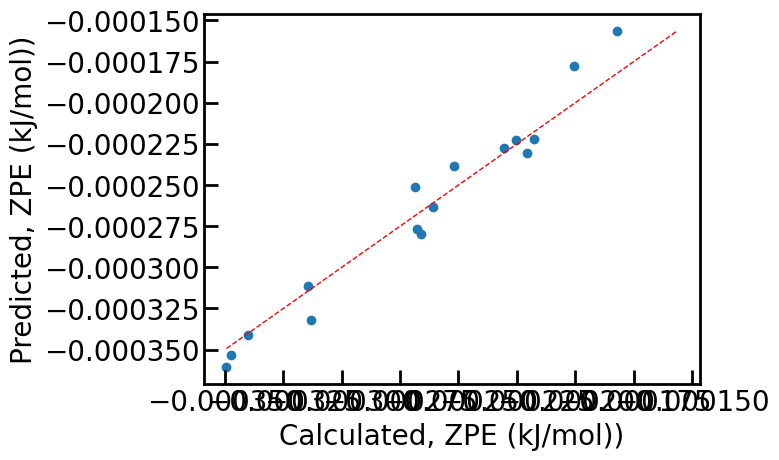

gpr2 0.9644542650770789
RMSE:  0.04571849540458857
RMSE unscaled:  9.717358034155428e-06
----------------------------------------


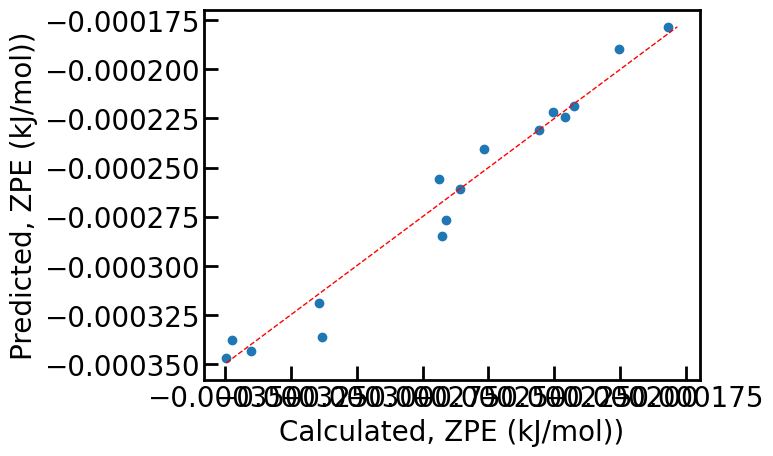

gpr3 0.9727088415938693
RMSE:  0.04005983586023304
RMSE unscaled:  8.514623335664579e-06
----------------------------------------


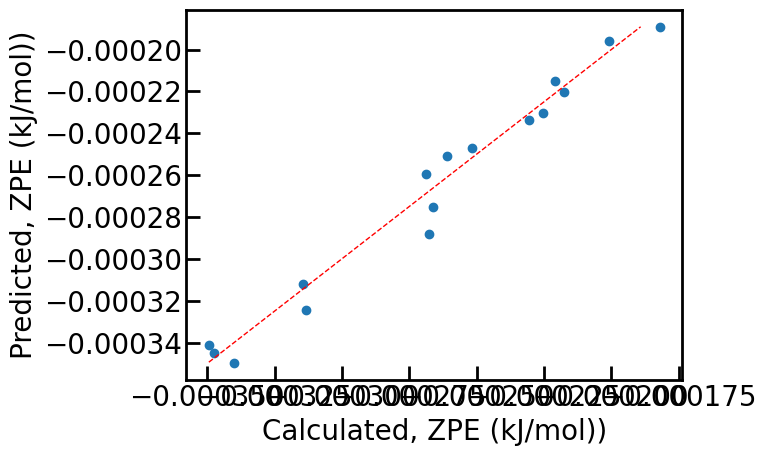

gpr4 0.9727088416264944
RMSE:  0.040059835836288415
RMSE unscaled:  8.514623330575198e-06
----------------------------------------


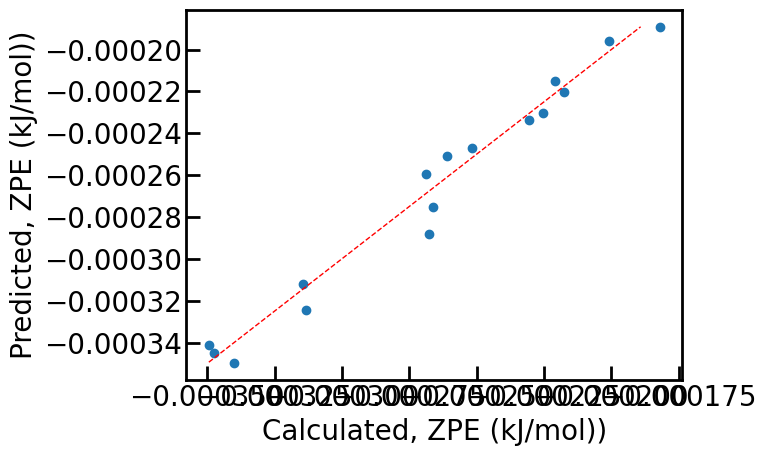

gpr5 0.9645803969558548
RMSE:  0.04563730866867417
RMSE unscaled:  9.700101985514221e-06
----------------------------------------


gpr6 0.9773916695329743
RMSE:  0.036461323312915996
RMSE unscaled:  7.749768007350968e-06
----------------------------------------


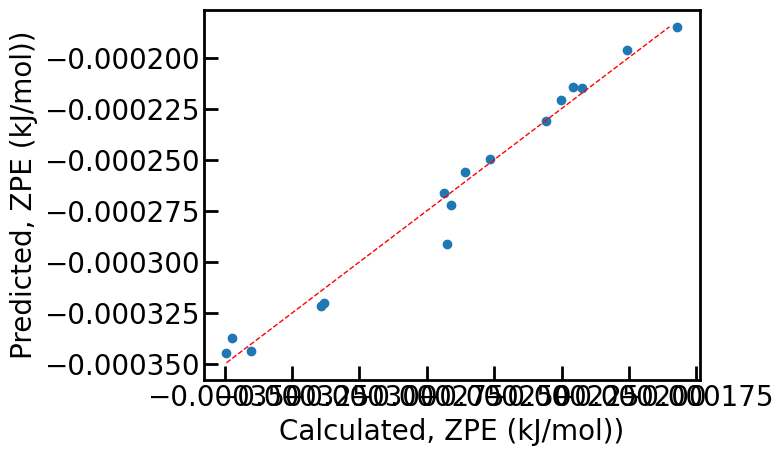

In [43]:
run_models()

In [44]:
featureScores.nlargest(20,'Score')['Feature'].values

array(['mean_A2B', 'X_EA', 'X_Z', 'X_Rvdw', 'mean_X2X', 'A_Rvdw',
       'mean_A2X', 'A_IEI', 'E_coh', 'B_Hf', 'A_ChiA', 'A_ChiP', 'X_G',
       'B_Ra', 'X_Kappa', 'std_A2X', 'B_MP', 'A_EA', 'std_B2X', 'A_MP'],
      dtype=object)

In [45]:
X=X[featureScores.nlargest(20,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(20,'Score')['Feature'].values]

RF 0.9297398984518142
RMSE:  0.06427655128903008
RMSE unscaled:  1.3661828906416105e-05
----------------------------------------


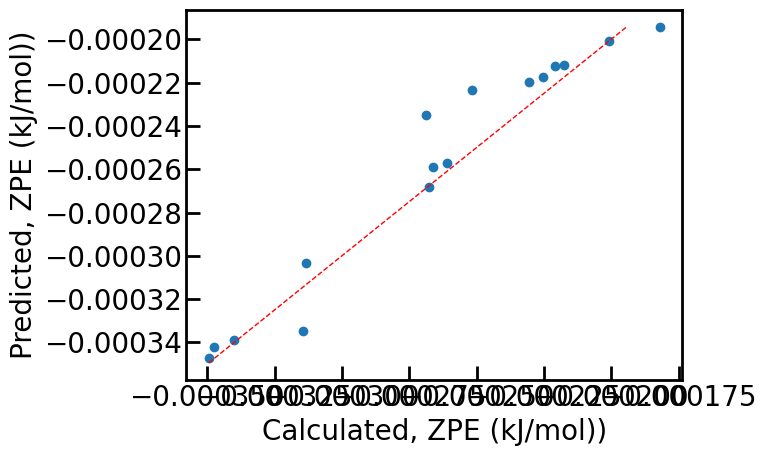

GB 0.8814748561131428
RMSE:  0.0834840339463787
RMSE unscaled:  1.774433390279783e-05
----------------------------------------


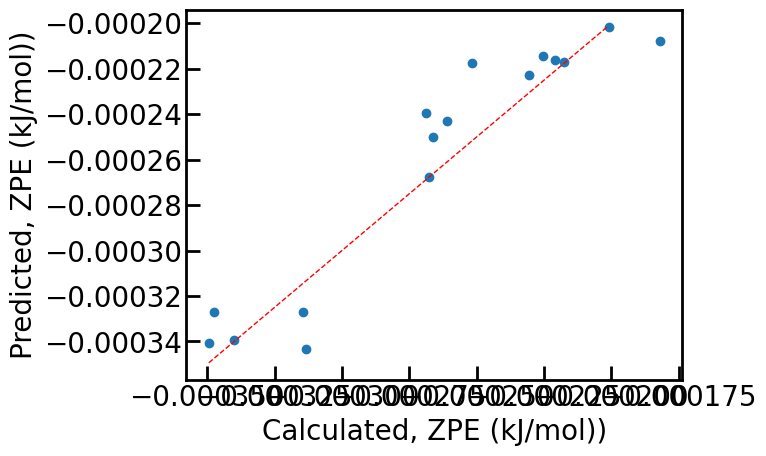

LR 0.9390688944912577
RMSE:  0.059857380796114065
RMSE unscaled:  1.2722544673336765e-05
----------------------------------------


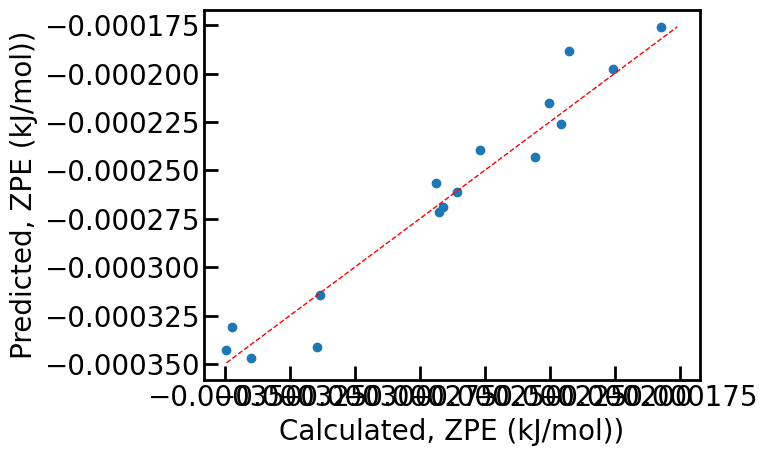

RR 0.9442970870325171
RMSE:  0.05723176425927264
RMSE unscaled:  1.2164476090302719e-05
----------------------------------------


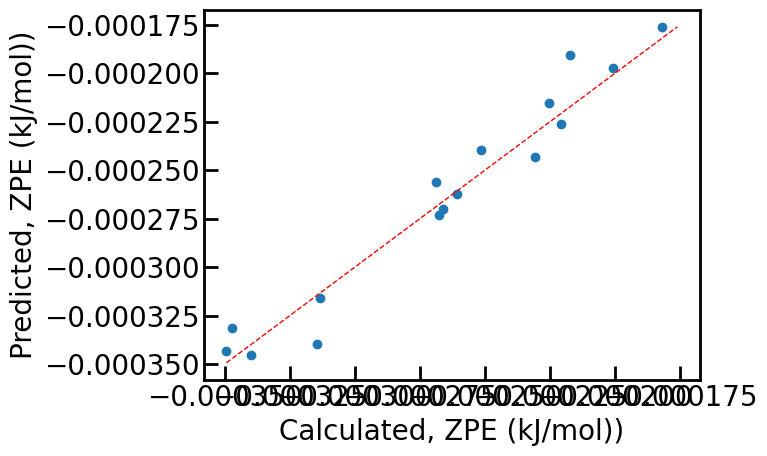

LASSO 0.907976054418522
RMSE:  0.0735611661450755
RMSE unscaled:  1.5635251827861947e-05
----------------------------------------


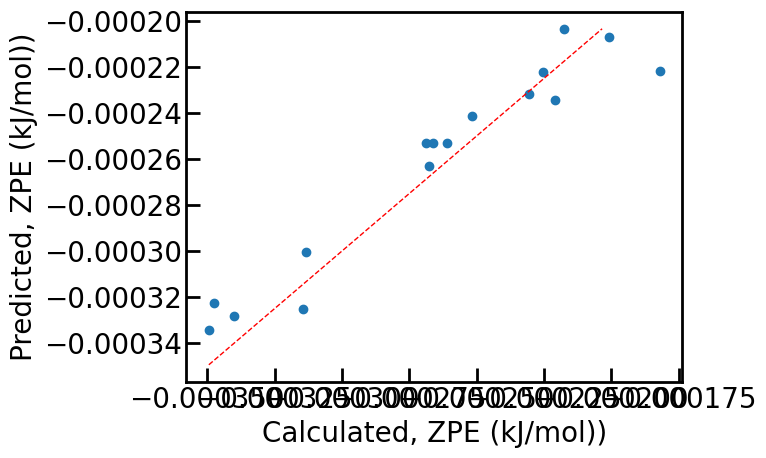

gpr1 0.9423471375506794
RMSE:  0.05822488209672562
RMSE unscaled:  1.2375560937064065e-05
----------------------------------------


gpr2 0.9642547057302608
RMSE:  0.04584665119675951
RMSE unscaled:  9.744597244581212e-06
----------------------------------------


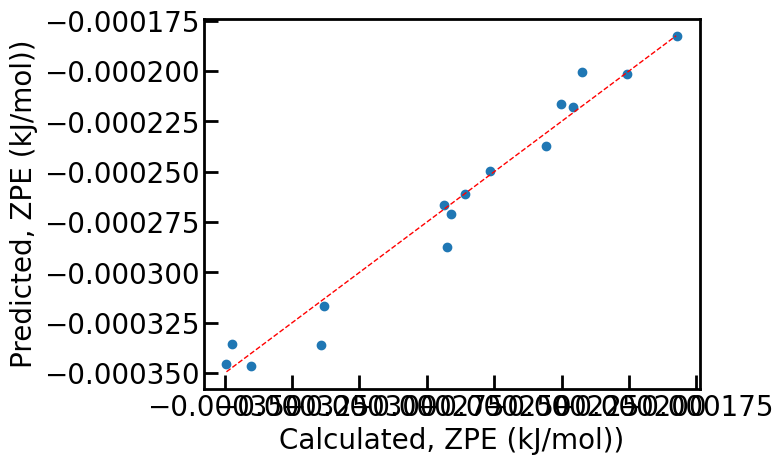

gpr3 0.9284798855495856
RMSE:  0.06485034349617577
RMSE unscaled:  1.3783787082526238e-05
----------------------------------------


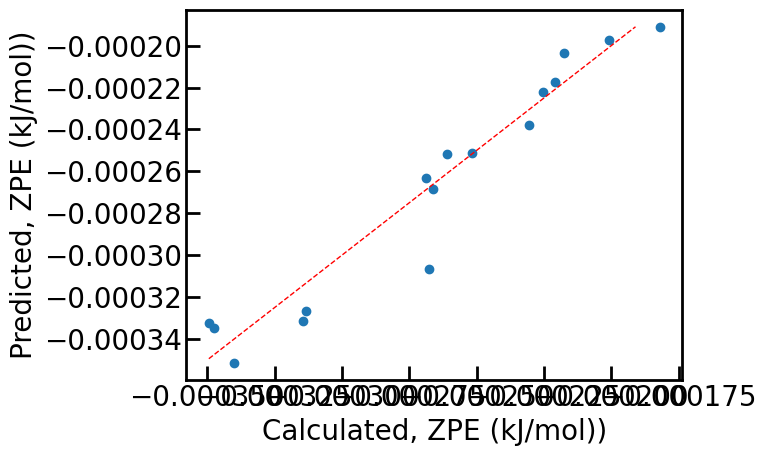

gpr4 0.9284798772325901
RMSE:  0.06485034726686323
RMSE unscaled:  1.3783787883976936e-05
----------------------------------------


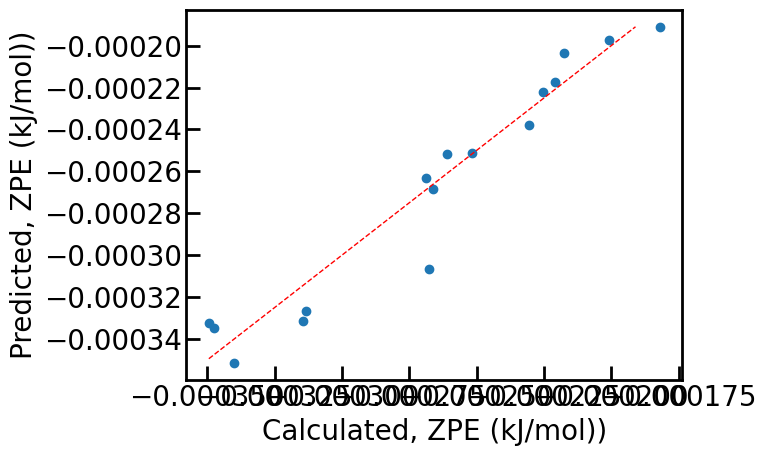

gpr5 0.9504434030642406
RMSE:  0.053981993453896975
RMSE unscaled:  1.1473744994160583e-05
----------------------------------------


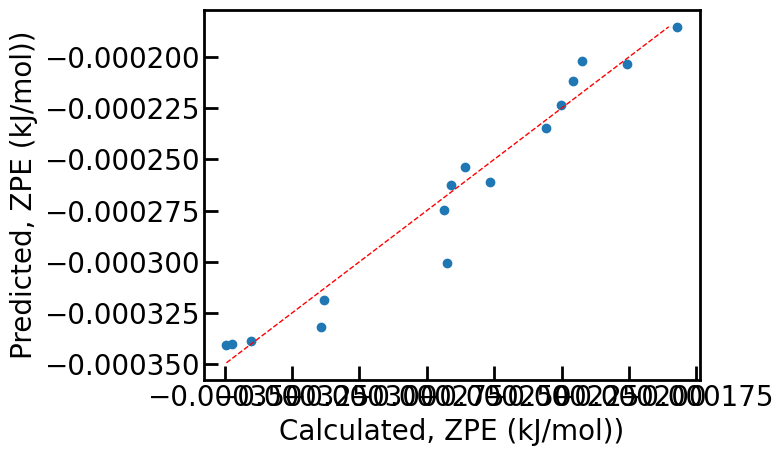

gpr6 0.9701106542629454
RMSE:  0.04192338917912723
RMSE unscaled:  8.910717184667666e-06
----------------------------------------


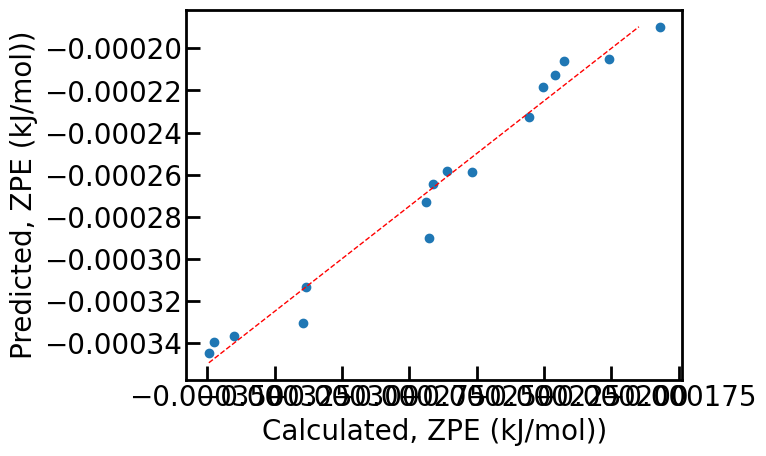

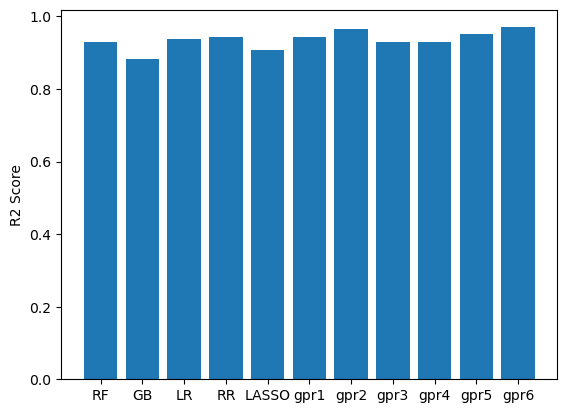

In [46]:
run_models()

In [47]:
featureScores.nlargest(10,'Score')['Feature'].values

array(['mean_A2B', 'X_EA', 'X_Z', 'X_Rvdw', 'mean_X2X', 'A_Rvdw',
       'mean_A2X', 'A_IEI', 'E_coh', 'B_Hf'], dtype=object)

In [48]:
X=X[featureScores.nlargest(10,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(10,'Score')['Feature'].values]

RF 0.930280232223784
RMSE:  0.0640289155559378
RMSE unscaled:  1.3609194517221688e-05
----------------------------------------


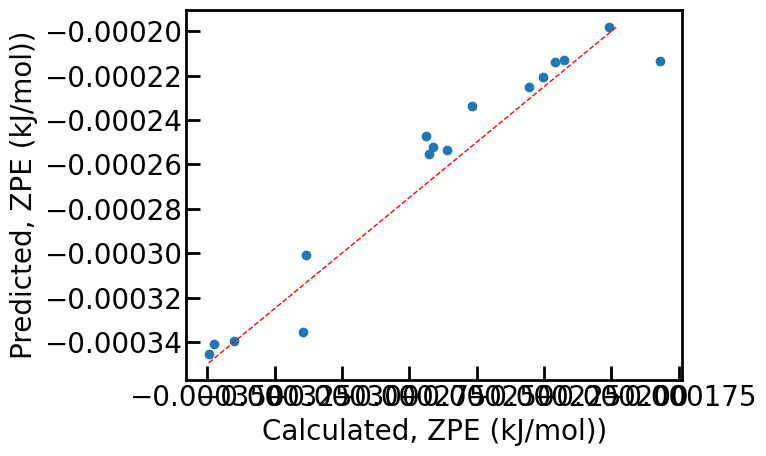

GB 0.9674238641183774
RMSE:  0.04376711945250752
RMSE unscaled:  9.302597692245541e-06
----------------------------------------


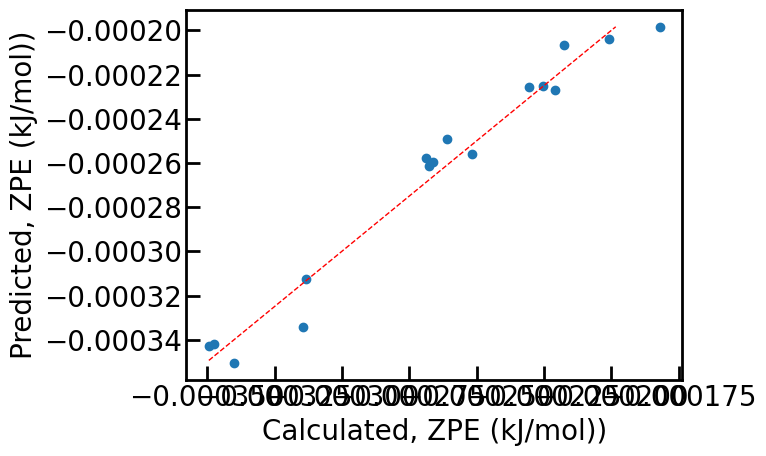

LR 0.9441959188733882
RMSE:  0.05728371311914646
RMSE unscaled:  1.2175517697564568e-05
----------------------------------------


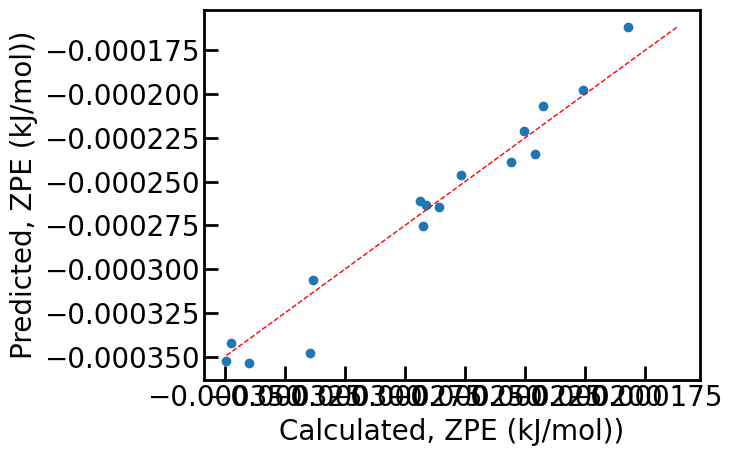

RR 0.9458850925415945
RMSE:  0.056410070232910475
RMSE unscaled:  1.1989826969022007e-05
----------------------------------------


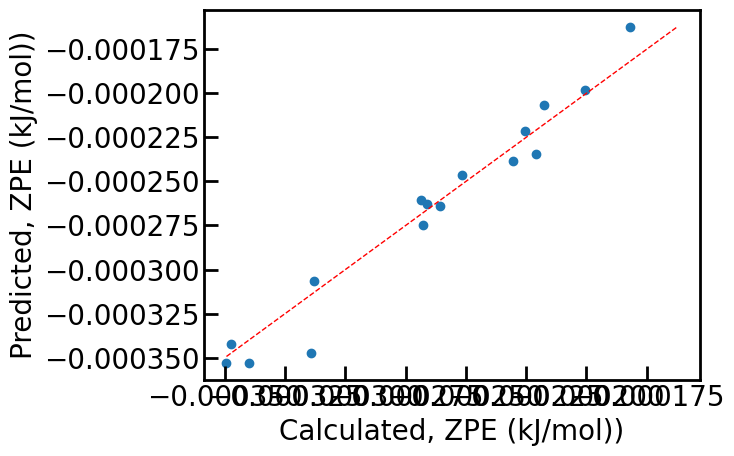

LASSO 0.8911549476444549
RMSE:  0.08000230993136015
RMSE unscaled:  1.7004301700717606e-05
----------------------------------------


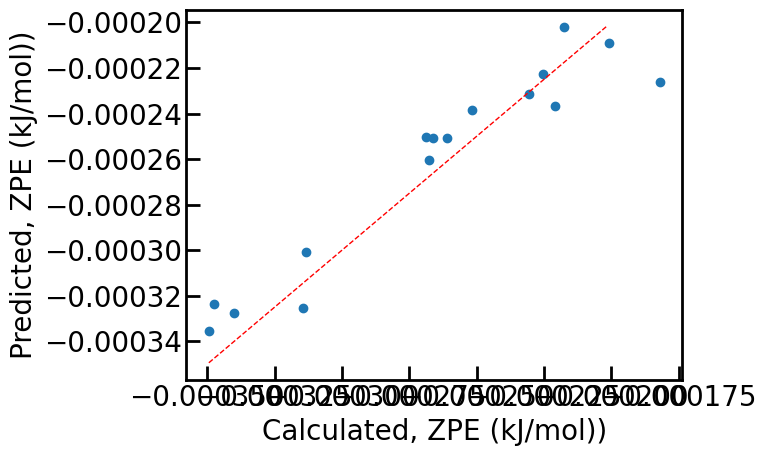

gpr1 0.9459752018955189
RMSE:  0.05636308509513119
RMSE unscaled:  1.1979840389147823e-05
----------------------------------------


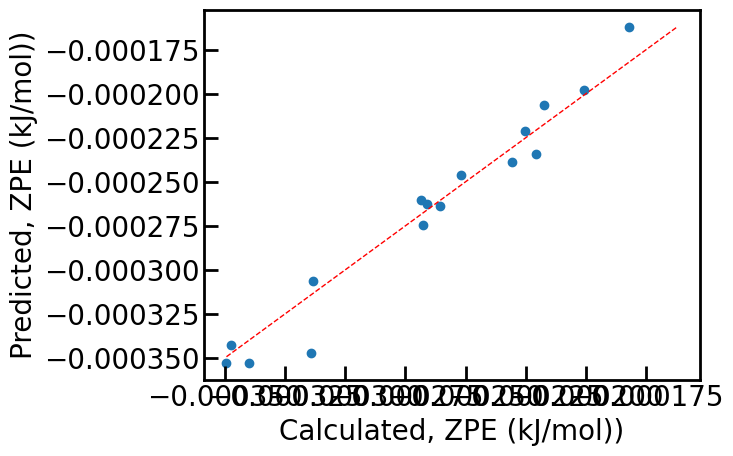

gpr2 0.960961465741239
RMSE:  0.04791206971798823
RMSE unscaled:  1.018359706475336e-05
----------------------------------------


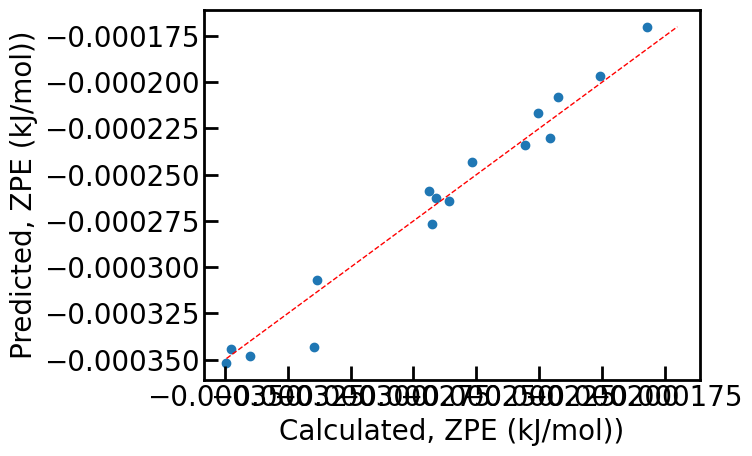

gpr3 0.801130769604725
RMSE:  0.1081389073077501
RMSE unscaled:  2.2984668905492626e-05
----------------------------------------


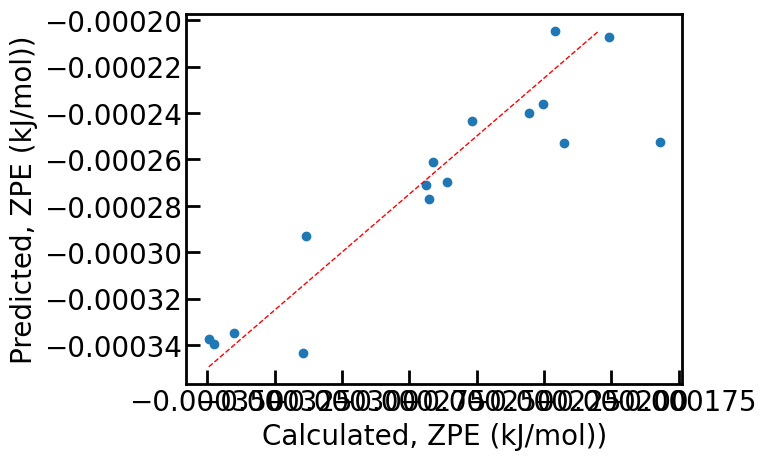

gpr4 0.8011307735796396
RMSE:  0.10813890622703258
RMSE unscaled:  2.2984668675788682e-05
----------------------------------------


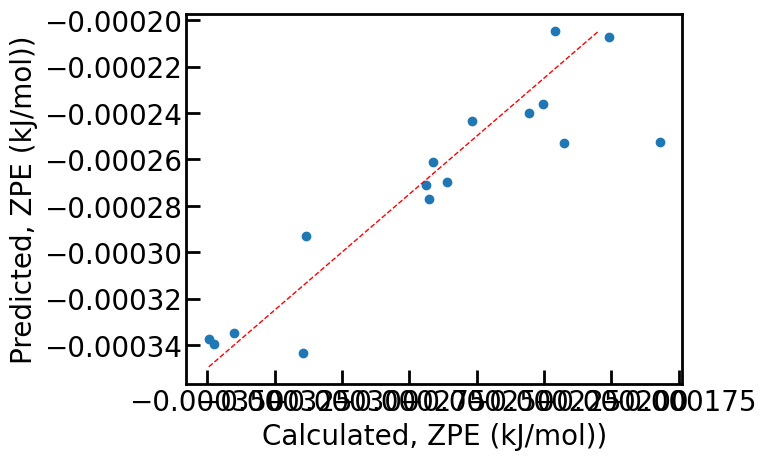

gpr5 0.9768045397821097
RMSE:  0.03693173215857425
RMSE unscaled:  7.849752294568707e-06
----------------------------------------


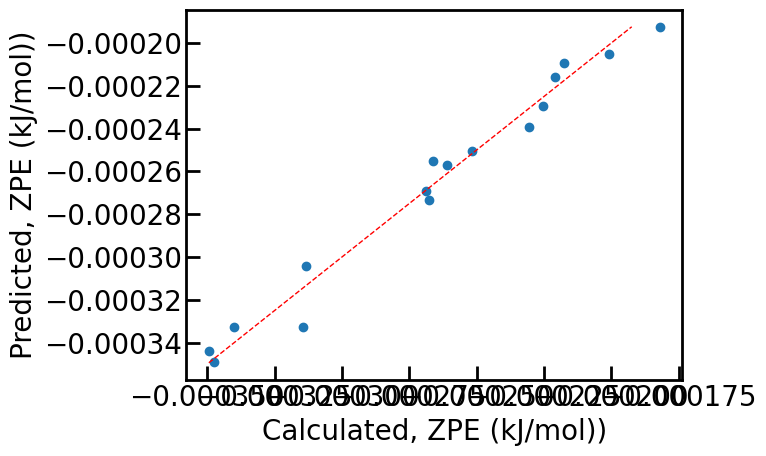

gpr6 0.9817692956339432
RMSE:  0.03274160046422315
RMSE unscaled:  6.9591497162479565e-06
----------------------------------------


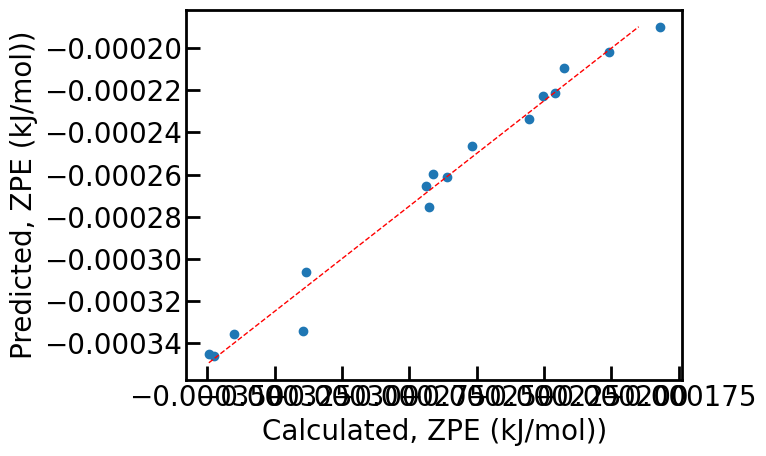

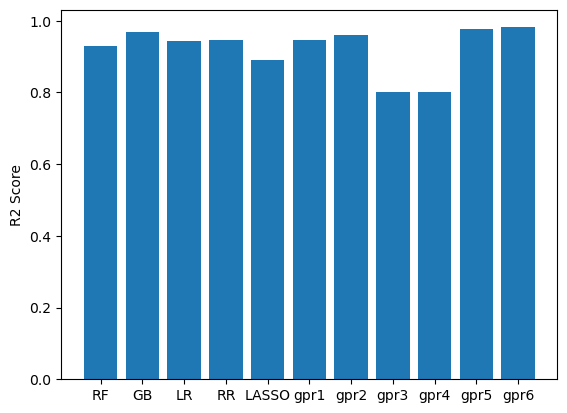

In [49]:
run_models()